In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import struct
import scipy.fft
from scipy.fft import fftshift
from scipy.fft import fftfreq
from scipy.io import loadmat,savemat
from scipy.interpolate import griddata
matplotlib.rcParams['font.size'] = 16
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter

######### loadinfo function
def loadinfo(dir):
    fstr = dir + "info"
    fd = open(fstr,"rb")
    infocontent = fd.read()
    fd.close
    arr = struct.unpack("fIIIffffff", infocontent[:40])
    infoarr=np.zeros(6)
    infoarr[0] = arr[1]
    infoarr[1] = arr[2]
    infoarr[2] = arr[3]
    infoarr[3] = arr[6]
    infoarr[4] = arr[7]
    infoarr[5] = arr[8]
    print(infoarr)
    return infoarr
######### end loadSlice


######### loadSlice function
def loadSlice(dir,q,sl,nx,ny,nz):
    fstr = dir + q + ".gda"
    fd = open(fstr,"rb")
    fd.seek(4*sl*nx*ny*nz,1)
    arr = np.fromfile(fd,dtype=np.float32,count=nx*ny*nz)
    fd.close
    arr = np.reshape(arr,(nz, ny, nx))
    arr = np.transpose(arr, axes=(2, 1, 0))
    return arr
######### end loadSlice

def get_psd(array,dx=0.5,dy=0.5,dt=2.56):
    dim = array.ndim
    if dim == 2:
        FS = (scipy.fft.fftn(array, axes=(0,1)))
        psd = np.abs(FS)**2/(FS.size * dx * dy)
    elif dim == 3:
        FS = (scipy.fft.fftn(array, axes=(0,1,2)))
        psd = np.abs(FS)**2/(FS.size * dx * dy * dt)
    return psd  


######### Make a gif
def makeGIF(imdir, basename, slicenums, imageext):
    images = [(imdir + basename + '_' + str(index) + imageext) for index in slicenums]
    filename = imdir+'../'+basename+'.gif'
    with open(imdir + basename+'_list.txt','w') as fil:
        for item in images:
            fil.write("%s\n" % item)
    os.chdir(imdir)
    os.system('convert @'+basename+'_list.txt '+filename)
########
def get_parameter_index_in_np_array(array, sub_array):
    sub_idx = np.array([], dtype=int)
    for i in sub_array:
        indices = np.where(array == i)[0]  # 获取所有匹配索引
        sub_idx = np.concatenate((sub_idx, indices))
    return sub_idx
cmap = plt.get_cmap("Spectral")

Q = {}
Q_3d = {}
qs = ["ni","bx","by","bz","uix","uiy","uiz","pi-xx","pi-yy","pi-zz","ex","ey","ez"]
# qs = ["bx","by","bz","ex","ey","ez"]
dir = "data_0resistivity/"
# dir = "/Users/chuanpeng/research/alfven_turbulence/data_2kx_amp002/"
infoarr = loadinfo(dir)
nx = int(infoarr[0])
ny = int(infoarr[1])
nz = int(infoarr[2])
Lx = int(infoarr[3])
Ly = int(infoarr[4])
Lz = int(infoarr[5])
print(infoarr)

dx = Lx/nx
dy = Ly/ny
dz = Lz/nz
dt = 2.56


#mark
t_idx_start = 0
t_idx_end = 5
t_idx_step = 1

calculate_w_k = 1
use_cwt_2DT_CPU = 0
use_cwt_2DT_GPU = 1
re_calc = 0

W_thermal_arr = np.array([])

xv = np.linspace(0,Lx,nx)-Lx/2.0
yv = np.linspace(0,Ly,ny)-Ly/2.0
zv = np.linspace(0,Lz,nz)-Lz/2.0
slicenums = []

for q in qs:
    slices = []
    for slice_ in range(t_idx_start, t_idx_end, t_idx_step):
#             print(slice)
            tmp = loadSlice(dir,q,slice_,nx,ny,nz)
            slices.append(tmp[:,:,:])
    Q_3d[q] = np.stack(slices, axis=-1)

variable = Q_3d['bx'][:,:,:,0]
vari_rms = np.sqrt(np.mean(variable**2) - np.mean(variable)**2)
print("vari_rms: ", vari_rms)

[256. 256. 256.  64.  64.  64.]
[256. 256. 256.  64.  64.  64.]
vari_rms:  0.23400667972638842


In [3]:
import math
def find_nearest_lattice(r1, direction, l):
    """
    在三维格点中，找到沿指定方向、距离起始格点r1为l的最近格点。
    
    参数:
        r1 (tuple/list): 起始格点坐标，需为3个整数，如(1, 2, 3)
        direction (tuple/list): 方向向量，需为3个数字，如(1.0, 1.0, 0.0)
        l (float/int): 距离，需为正数
    
    返回:
        tuple: 最近的格点坐标（3个整数）
    
    异常:
        ValueError: 输入参数不符合要求时抛出
    """
    # 验证起始格点r1的有效性（3个整数）
    if not (isinstance(r1, (tuple, list)) and len(r1) == 3 and all(isinstance(x, int) for x in r1)):
        raise ValueError("r1必须是包含3个整数的元组或列表")
    
    # 验证方向向量的有效性（3个数字）
    if not (isinstance(direction, (tuple, list)) and len(direction) == 3):
        raise ValueError("direction必须是包含3个数字的元组或列表")
    
    # 验证距离l的有效性（正数）
    if not (isinstance(l, (int, float)) and l > 0):
        raise ValueError("l必须是正数")
    
    # 解析方向向量分量
    vx, vy, vz = direction
    
    # 计算方向向量的模长（避免零向量）
    mod = math.sqrt(vx**2 + vy**2 + vz**2)
    if mod < 1e-10:  # 考虑浮点数精度误差
        raise ValueError("方向向量不能是零向量")
    
    # 归一化方向向量（得到单位向量）
    nx = vx / mod
    ny = vy / mod
    nz = vz / mod
    
    # 计算沿方向移动距离l后的目标点坐标（非格点）
    px = r1[0] + l * nx
    py = r1[1] + l * ny
    pz = r1[2] + l * nz
    
    # 四舍五入得到最近的格点（各分量取最近整数）
    nearest_lattice = (round(px), round(py), round(pz))
    
    return nearest_lattice

In [4]:
def calc_3x3_matrices_eigen(matrices):
    """
    计算N个3×3矩阵的特征值和特征向量。
    
    参数:
        matrices (np.ndarray): 输入的N个3×3矩阵，形状必须为 (N, 3, 3)，
                              其中N为矩阵数量，每个元素为3×3矩阵。
    
    返回:
        eigenvals (np.ndarray): 每个矩阵的特征值，形状为 (N, 3)，
                               数据类型为复数（因非对称矩阵可能有复特征值）。
        eigenvecs (np.ndarray): 每个矩阵的特征向量，形状为 (N, 3, 3)，
                               其中 eigenvecs[i, :, m] 表示第i个矩阵的第m个特征值对应的特征向量（列向量），
                               数据类型为复数。
    
    说明:
        - 对于对称矩阵，特征值为实数，特征向量正交；对于非对称矩阵，可能返回复特征值和特征向量。
        - 依赖 numpy.linalg.eig 实现，特征向量按列存储（与numpy默认一致）。
    """
    # 输入校验
    if matrices.ndim != 3 or matrices.shape[1:] != (3, 3):
        raise ValueError(f"输入必须是形状为 (N, 3, 3) 的3维数组，当前形状为 {matrices.shape}")
    
    N = matrices.shape[0]  # 矩阵数量
    # 初始化结果数组（复数类型，兼容复特征值/向量）
    eigenvals = np.zeros((N, 3), dtype=np.complex128)
    eigenvecs = np.zeros((N, 3, 3), dtype=np.complex128)
    
    # 遍历每个矩阵计算特征值和特征向量
    for i in range(N):
        mat = matrices[i]  # 取出第i个3×3矩阵
        # 计算特征值和特征向量（eig返回：特征值数组(3,), 特征向量矩阵(3,3)，每列是一个特征向量）
        evals, evecs = np.linalg.eig(mat)
        eigenvals[i] = evals  # 存储第i个矩阵的特征值
        eigenvecs[i] = evecs  # 存储第i个矩阵的特征向量（保持列向量结构）
    
    return eigenvals, eigenvecs

In [5]:
def calc_vector_field_jacobian_eigen(vector_field, hx, hy, hz):
    """
    计算三维矢量场的雅可比矩阵（一阶梯度矩阵）的特征值和特征向量。
    
    参数:
        vector_field (np.ndarray): 三维矢量场数据，形状为 (nx, ny, nz, 3)，
                                 最后一个维度对应3个分量（如 [Bx, By, Bz]）。
        hx (float): x方向空间步长（相邻网格x坐标差），必须为正数。
        hy (float): y方向空间步长，必须为正数。
        hz (float): z方向空间步长，必须为正数。
    
    返回:
        eigenvals (np.ndarray): 每个网格点的雅可比矩阵特征值，形状为 (nx, ny, nz, 3)，
                               特征值可能为复数（因雅可比矩阵不一定对称）。
        eigenvecs (np.ndarray): 每个网格点的雅可比矩阵特征向量，形状为 (nx, ny, nz, 3, 3)，
                               其中eigenvecs[i,j,k,:,m]对应第m个特征值的特征向量，
                               特征向量可能为复数。
    
    数值方法:
        - 内部网格点：采用**中心差分**（二阶精度）计算一阶偏导数。
        - 边界网格点：采用**向前/向后差分**（一阶精度）避免越界。
    """
    # 输入校验
    if vector_field.ndim != 4 or vector_field.shape[-1] != 3:
        raise ValueError(f"矢量场必须是形状为 (nx, ny, nz, 3) 的4维数组，当前形状为 {vector_field.shape}")
    if hx <= 0 or hy <= 0 or hz <= 0:
        raise ValueError(f"空间步长必须为正数，当前 hx={hx}, hy={hy}, hz={hz}")
    
    nx, ny, nz, _ = vector_field.shape
    # 存储特征值（可能为复数）
    eigenvals = np.zeros((nx, ny, nz, 3), dtype=np.complex128)
    # 存储特征向量（最后两个维度：3个特征向量，每个为3维向量）
    eigenvecs = np.zeros((nx, ny, nz, 3, 3), dtype=np.complex128)
    
    # 定义一阶偏导数计算函数（处理边界）
    def first_deriv(arr, axis, h):
        """
        计算数组沿指定轴的一阶偏导数。
        参数:
            arr: 输入数组（形状为 (nx, ny, nz)）
            axis: 求导轴（0=x, 1=y, 2=z）
            h: 该轴的空间步长
        返回:
            deriv: 与arr同形状的一阶导数数组
        """
        deriv = np.zeros_like(arr, dtype=np.float64)
        n = arr.shape[axis]  # 该轴的网格点数
        
        # 内部点：中心差分 (f[i+1] - f[i-1])/(2h)
        slices = [slice(None)] * 3
        slices[axis] = slice(1, n-1)  # 内部索引
        slices_plus = [slice(None)] * 3
        slices_plus[axis] = slice(2, n)  # i+1
        slices_minus = [slice(None)] * 3
        slices_minus[axis] = slice(0, n-2)  # i-1
        deriv[tuple(slices)] = (arr[tuple(slices_plus)] - arr[tuple(slices_minus)]) / (2 * h)
        
        # 边界点：首边界用向前差分 (f[1] - f[0])/h
        slices_first = [slice(None)] * 3
        slices_first[axis] = 0
        slices_first_plus = [slice(None)] * 3
        slices_first_plus[axis] = 1
        deriv[tuple(slices_first)] = (arr[tuple(slices_first_plus)] - arr[tuple(slices_first)]) / h
        
        # 边界点：尾边界用向后差分 (f[-1] - f[-2])/h
        slices_last = [slice(None)] * 3
        slices_last[axis] = -1
        slices_last_minus = [slice(None)] * 3
        slices_last_minus[axis] = -2
        deriv[tuple(slices_last)] = (arr[tuple(slices_last)] - arr[tuple(slices_last_minus)]) / h
        
        return deriv
    
    # 计算雅可比矩阵的9个元素（3个分量×3个方向的偏导数）
    # Bx的偏导数：∂Bx/∂x, ∂Bx/∂y, ∂Bx/∂z
    d_Bx_dx = first_deriv(vector_field[..., 0], axis=0, h=hx)
    d_Bx_dy = first_deriv(vector_field[..., 0], axis=1, h=hy)
    d_Bx_dz = first_deriv(vector_field[..., 0], axis=2, h=hz)
    
    # By的偏导数：∂By/∂x, ∂By/∂y, ∂By/∂z
    d_By_dx = first_deriv(vector_field[..., 1], axis=0, h=hx)
    d_By_dy = first_deriv(vector_field[..., 1], axis=1, h=hy)
    d_By_dz = first_deriv(vector_field[..., 1], axis=2, h=hz)
    
    # Bz的偏导数：∂Bz/∂x, ∂Bz/∂y, ∂Bz/∂z
    d_Bz_dx = first_deriv(vector_field[..., 2], axis=0, h=hx)
    d_Bz_dy = first_deriv(vector_field[..., 2], axis=1, h=hy)
    d_Bz_dz = first_deriv(vector_field[..., 2], axis=2, h=hz)
    
    # 遍历每个网格点，构建雅可比矩阵并计算特征值和特征向量
    for i in range(nx):
        print(i)
        for j in range(ny):
            for k in range(nz):
                
                # 构建当前点的3×3雅可比矩阵
                jacobian = np.array([
                    [d_Bx_dx[i, j, k], d_Bx_dy[i, j, k], d_Bx_dz[i, j, k]],
                    [d_By_dx[i, j, k], d_By_dy[i, j, k], d_By_dz[i, j, k]],
                    [d_Bz_dx[i, j, k], d_Bz_dy[i, j, k], d_Bz_dz[i, j, k]]
                ], dtype=np.float64)
                symmetric_jacobian = 0.5 * (jacobian + jacobian.T)  # 对称化雅可比矩阵，以防奇异
                
                # 计算特征值和特征向量（雅可比矩阵可能非对称，用eig求复特征值/向量）
                evals, evecs = np.linalg.eig(jacobian)  # evecs每一列是一个特征向量
                eigenvals[i, j, k] = evals
                # 存储特征向量（保持与特征值的对应关系）
                eigenvecs[i, j, k] = evecs  # 形状为(3,3)，每列对应一个特征值的特征向量
    
    return eigenvals, eigenvecs

In [6]:
from scipy.interpolate import RegularGridInterpolator
import os

import imageio
import matplotlib.pyplot as plt
import numpy as np
from spacepy.pybats import IdlFile
import pyvista as pv
from pyvista import examples
import pyvista
import pyvista as pv
import numpy as np

def rotate_z(points, angle_deg):
    """
    将一组三维点绕Z轴旋转指定角度（单位：度）

    参数：
    - points: (N, 3) ndarray
    - angle_deg: 旋转角度（单位：度）

    返回：
    - rotated_points: (N, 3) ndarray，旋转后的点
    """
    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    
    Rz = np.array([
        [cos_a, -sin_a, 0],
        [sin_a,  cos_a, 0],
        [0,      0,     1]
    ])
    
    return points @ Rz.T  # 注意右乘转置
def plot_tetrahedron(p, points=None, show_faces=True, size_ratio=1.0):
    """
    绘制一个四面体，顶点为黑点，边为虚线。

    参数：
    - points: (4, 3) 的 ndarray，指定四面体的四个顶点坐标；若为 None，则使用默认四面体。
    - show_faces: 是否绘制透明的面（默认 True）

    返回：
    - plotter: 返回 PyVista 的 Plotter 对象
    """
    # 默认的四面体顶点
    if points is None:
        points = np.array([
            [0, 0, 0],
            [1, 0, 0],
            [0.5, 1, 0],
            [0.5, 0.5, 1]
        ])
    if points.shape != (4, 3):
        raise ValueError("points 必须是一个形状为 (4, 3) 的 ndarray")
    # 构建单个四面体单元
    cells = np.hstack([[4, 0, 1, 2, 3]])
    celltypes = np.array([10])  # VTK_TETRA = 10
    # 构建UnstructuredGrid
    tetra = pv.UnstructuredGrid(cells, celltypes, points)
    # 可选：绘制透明面
    if show_faces:
        p.add_mesh(tetra, color='lightblue', opacity=0.12, show_edges=False)
    # 虚线边框
    edges = tetra.extract_all_edges()
    p.add_mesh(edges, color='black', line_width=2)
    # 顶点黑点
    p.add_points(points, color='black', point_size=10*size_ratio, render_points_as_spheres=True)
    return p
def create_regular_tetrahedron(L=25, center=np.array([0, 0, 0])):
    """
    创建一个等边四面体，边长为L，中心在给定的center。

    返回：四个顶点坐标 (4, 3) ndarray
    """
    # 基于原点构造四面体顶点
    A = np.array([0, 0, 0])
    B = np.array([L, 0, 0])
    C = np.array([L/2, L*np.sqrt(3)/2, 0])
    D = np.array([L/2, L/(2*np.sqrt(3)), L*np.sqrt(6)/3])

    # 平移到指定中心（默认原点）
    verts = np.array([A, B, C, D])
    centroid = np.mean(verts, axis=0)
    shifted = verts - centroid + center

    return shifted
def creat_triangulated_grid(data, infoarr, vari='Ux', tidx=0):
    variable = np.array(data[vari][:,:,:,tidx])
    nx = int(infoarr[0])
    ny = int(infoarr[1])
    nz = int(infoarr[2])
    Lx = int(infoarr[3])
    Ly = int(infoarr[4])
    Lz = int(infoarr[5])
    dx = Lx/nx
    dy = Ly/ny
    dz = Lz/nz
    origin = (-Lx/2, -Ly/2, -Lz/2)
    print("nx, ny, nz: ", nx, ny, nz)
    print("Lx, Ly, Lz: ", Lx, Ly, Lz)
    print("shape of variable: ", variable.shape)
    dimensions = (nx, ny, nz)
    spacing = (dx, dy, dz)
    box_grid = pv.ImageData(dimensions=(dimensions[0], dimensions[1], dimensions[2]), spacing=spacing,
                            origin=origin)
    box_grid.point_data[vari] = variable.ravel('F')
    return box_grid
 
vari = 'bz'
tidx = 4
p = pyvista.Plotter()
box_grid = creat_triangulated_grid(data=Q_3d, infoarr=infoarr, vari=vari, tidx=tidx)
# slice
three_slice = box_grid.slice_orthogonal(x=-30, y=-30, z=-20)
# single_slice = box_grid.slice(normal=[0, 80, 45])
p.add_mesh(three_slice, scalars=vari, cmap='hot', opacity=1.0, scalar_bar_args={'color': "black"})#, clim=(0,0.005)
p.add_axes(line_width=5, labels_off=False, color='black')

outer_points = create_regular_tetrahedron(L=60*dx, center=np.array([0, 0, 0]))
print(outer_points)
rotated_points = rotate_z(outer_points, 15)
plot_tetrahedron(p, rotated_points, size_ratio=1.0)

middle_points = create_regular_tetrahedron(L=40*dx, center=np.array([0, 0, 0]))
middle_rotated_points = rotate_z(middle_points, 180)
plot_tetrahedron(p, middle_rotated_points, size_ratio=1.0)

inner_points = create_regular_tetrahedron(L=20*dx, center=np.array([0, 0, 0]))
rotated_points = rotate_z(inner_points, 5)
plot_tetrahedron(p, rotated_points, size_ratio=1.0)
all_satellites = np.vstack([inner_points, middle_rotated_points, outer_points])
reference_point = np.mean(all_satellites, axis=0)
N = len(all_satellites)
A = np.ones((N, 4))
for i in range(N):
    delta_r = all_satellites[i] - reference_point
    A[i, 0] = delta_r[0]  # δx
    A[i, 1] = delta_r[1]  # δy  
    A[i, 2] = delta_r[2]  # δz
    # A[i, 3] = 1 已经初始化为1
x = np.linspace(-32, 32-dx, 256)
y = np.linspace(-32, 32-dx, 256)
z = np.linspace(-32, 32-dx, 256)
Bx, By, Bz = Q_3d['bx'][:,:,:,1], Q_3d['by'][:,:,:,1], Q_3d['bz'][:,:,:,1]
interpolated_B = np.zeros((N, 3))

interp_Bx = RegularGridInterpolator((x, y, z), Bx)
interp_By = RegularGridInterpolator((x, y, z), By)
interp_Bz = RegularGridInterpolator((x, y, z), Bz)
print(x[nx//2])
for i in range(N):
            pos = all_satellites[i]
            Bx_val = interp_Bx(pos)
            By_val = interp_By(pos)
            Bz_val = interp_Bz(pos)
            interpolated_B[i] = np.squeeze(np.array([Bx_val, By_val, Bz_val]))
# 使用最小二乘法求解
X, residuals, rank, s = np.linalg.lstsq(A, interpolated_B[:,0], rcond=None)
# print(np.mean(all_satellites, axis=0))
print(np.gradient(Bx, axis=0)[nx//2, ny//2, nz//2], np.gradient(Bx, axis=1)[nx//2, ny//2, nz//2], np.gradient(Bx, axis=2)[nx//2, ny//2, nz//2])
# 提取结果
gradient = X[:3]  # [Gx, Gy, Gz]
print(gradient)
# 创建一个光源
light = pv.Light()
light.position = [64, 64, 64]       # 设置光源位置
light.focal_point = [0, 0, 0]           # 照向的中心点
light.intensity = 0.6                  # 光照强度 (0~1)
light.color = 'white'                   # 光照颜色
light.light_type = 1        # 0: headlight, 1: camera light, 2: scene light
p.add_light(light)
# p.add_text('t='+str(tidx*68), position="upper_edge", font_size=20, color="black")

# p.show(screenshot='/Users/chuanpeng/research/alfven_turbulence/figure/3D_'+str(tidx*68)+vari+'.png')  # 直接保存为 PNG 文件
p.show()


nx, ny, nz:  256 256 256
Lx, Ly, Lz:  64 64 64
shape of variable:  (256, 256, 256)
[[-7.50000000e+00 -4.33012702e+00 -3.06186218e+00]
 [ 7.50000000e+00 -4.33012702e+00 -3.06186218e+00]
 [ 0.00000000e+00  8.66025404e+00 -3.06186218e+00]
 [ 0.00000000e+00  8.88178420e-16  9.18558654e+00]]
0.0
-0.009673851 0.053374004 -0.012443608
[ 0.01371269  0.01282731 -0.03182534]


Widget(value="<iframe src='http://localhost:50411/index.html?ui=P_0x27ffc534e50_0&reconnect=auto' style='width…

In [7]:
x_pad = np.linspace(-32-dx/2, 32+dx/2, 258)
y_pad = np.linspace(-32-dx/2, 32+dx/2, 258)
z_pad = np.linspace(-32-dx/2, 32+dx/2, 258)
print(y_pad)
x,y,z = np.linspace(-32+dx/2, 32-dx/2, 256), np.linspace(-32+dx/2, 32-dx/2, 256), np.linspace(-32+dx/2, 32-dx/2, 256)
Bx, By, Bz = Q_3d['bx'][:,:,:,1], Q_3d['by'][:,:,:,1], Q_3d['bz'][:,:,:,1]
def mat_pad(Bx, nx=256, ny=256, nz=256):
    Bx_pad = np.zeros((nx+2, ny+2, nz+2))
    Bx_pad[1:nx+1,1:ny+1,1:nz+1] = Bx
    Bx_pad[0,1:ny+1,1:nz+1] = Bx[-1,:,:]
    Bx_pad[-1,1:ny+1,1:nz+1] = Bx[0,:,:]
    Bx_pad[1:nx+1,0,1:nz+1] = Bx[:,-1,:]
    Bx_pad[1:nx+1,-1,1:nz+1] = Bx[:,0,:]
    Bx_pad[1:nx+1,1:ny+1,0] = Bx[:,:,-1]
    Bx_pad[1:nx+1,1:ny+1,-1] = Bx[:,:,0]
    Bx_pad[0,0,0] = Bx[-1,-1,-1]
    Bx_pad[-1,0,0] = Bx[0,-1,-1]
    Bx_pad[0,-1,0] = Bx[-1,0,-1]
    Bx_pad[-1,-1,0] = Bx[0,0,-1]
    Bx_pad[0,0,-1] = Bx[-1,-1,0]
    Bx_pad[-1,0,-1] = Bx[0,-1,0]
    Bx_pad[0,-1,-1] = Bx[-1,0,0]
    Bx_pad[-1,-1,-1] = Bx[0,0,0]
    return Bx_pad
Bx_pad, By_pad, Bz_pad = mat_pad(Bx), mat_pad(By), mat_pad(Bz)
# print(Bx_pad[1,2,1],Bx[0,1,0])


interp_Bx = RegularGridInterpolator((x_pad, y_pad, z_pad), Bx_pad)
interp_By = RegularGridInterpolator((x_pad, y_pad, z_pad), By_pad)
interp_Bz = RegularGridInterpolator((x_pad, y_pad, z_pad), Bz_pad)
print(f"x轴边界：min={interp_Bx.grid[0].min()}, max={interp_Bx.grid[0].max()}")
# 维度1：对应y轴（错误提示中的dimension 1，你的问题出在这里）
print(f"y轴边界：min={interp_Bx.grid[1].min()}, max={interp_Bx.grid[1].max()}")
# 维度2：对应z轴（错误提示中的dimension 2）
print(f"z轴边界：min={interp_Bx.grid[2].min()}, max={interp_Bx.grid[2].max()}")

[-32.125 -31.875 -31.625 -31.375 -31.125 -30.875 -30.625 -30.375 -30.125
 -29.875 -29.625 -29.375 -29.125 -28.875 -28.625 -28.375 -28.125 -27.875
 -27.625 -27.375 -27.125 -26.875 -26.625 -26.375 -26.125 -25.875 -25.625
 -25.375 -25.125 -24.875 -24.625 -24.375 -24.125 -23.875 -23.625 -23.375
 -23.125 -22.875 -22.625 -22.375 -22.125 -21.875 -21.625 -21.375 -21.125
 -20.875 -20.625 -20.375 -20.125 -19.875 -19.625 -19.375 -19.125 -18.875
 -18.625 -18.375 -18.125 -17.875 -17.625 -17.375 -17.125 -16.875 -16.625
 -16.375 -16.125 -15.875 -15.625 -15.375 -15.125 -14.875 -14.625 -14.375
 -14.125 -13.875 -13.625 -13.375 -13.125 -12.875 -12.625 -12.375 -12.125
 -11.875 -11.625 -11.375 -11.125 -10.875 -10.625 -10.375 -10.125  -9.875
  -9.625  -9.375  -9.125  -8.875  -8.625  -8.375  -8.125  -7.875  -7.625
  -7.375  -7.125  -6.875  -6.625  -6.375  -6.125  -5.875  -5.625  -5.375
  -5.125  -4.875  -4.625  -4.375  -4.125  -3.875  -3.625  -3.375  -3.125
  -2.875  -2.625  -2.375  -2.125  -1.875  -1.625  -

In [8]:

def calc_gradient_matrix_with_muti_satellites(center,L_lst):
    # center = [20,15,0]
    L1,L2,L3 = L_lst
    outer_points = create_regular_tetrahedron(L=L3*dx, center=np.array(center))
    # print(outer_points)
    rotated_points = rotate_z(outer_points, 5)
    plot_tetrahedron(p, rotated_points, size_ratio=1.0)

    middle_points = create_regular_tetrahedron(L=L2*dx, center=np.array([0,0,0]))
    middle_rotated_points = rotate_z(middle_points, 180)+np.array(center)
    plot_tetrahedron(p, rotated_points, size_ratio=1.0)

    inner_points = create_regular_tetrahedron(L=L1*dx, center=np.array(center))
    rotated_points = rotate_z(inner_points, 5)
    plot_tetrahedron(p, rotated_points, size_ratio=1.0)
    all_satellites = np.vstack([inner_points, middle_rotated_points, outer_points])
    reference_point = np.mean(all_satellites, axis=0)
    N = len(all_satellites)
    A = np.ones((N, 4))
    for i in range(N):
        delta_r = all_satellites[i] - reference_point
        A[i, 0] = delta_r[0]  # δx
        A[i, 1] = delta_r[1]  # δy  
        A[i, 2] = delta_r[2]  # δz
        # A[i, 3] = 1 已经初始化为1

    interpolated_B = np.zeros((N, 3))
    # print(reference_point)

    # print(x[nx//2])
    for i in range(N):
                pos = (all_satellites[i]+32)%64-32+dx/2
                print(pos)
                       
                Bx_val = interp_Bx(pos)
                By_val = interp_By(pos)
                Bz_val = interp_Bz(pos)
                interpolated_B[i] = np.squeeze(np.array([Bx_val, By_val, Bz_val]))
    # 使用最小二乘法求解
    # print(interpolated_B.shape)
    X, residuals, rank, s = np.linalg.lstsq(A, interpolated_B, rcond=None)
    gradient = X[:3,:]
    return gradient.T
# print(X)
# print(np.mean(all_satellites, axis=0))
# print(interp_Bx(center),interp_By(center),interp_Bz(center))
# print(np.gradient(Bx, x, axis=0)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(By, x, axis=0)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(Bz, x, axis=0)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)])
# print(np.gradient(Bx, y, axis=1)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(By, y, axis=1)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(Bz, y, axis=1)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)])
# print(np.gradient(Bx, z, axis=2)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(By, z, axis=2)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(Bz, z, axis=2)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)])
# 提取结果
# Bx_gradient = X[:3]  # [Gx, Gy, Gz]
# print(gradient)

In [179]:
center = [-18.25,23.5,   12.5 ]
print(interp_Bx(np.array(center)+dx/2), Bx[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)])
a = calc_gradient_matrix_with_muti_satellites(center,L_lst=[1,2,3])
jacobian = np.array([
                    [np.gradient(Bx, x, axis=0)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(By, x, axis=0)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(Bz, x, axis=0)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)]],
                    [np.gradient(Bx, y, axis=1)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(By, y, axis=1)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(Bz, y, axis=1)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)]],
                    [np.gradient(Bx, z, axis=2)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(By, z, axis=2)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(Bz, z, axis=2)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)]]
                ], dtype=np.float64)
print(a)
b,c=calc_3x3_matrices_eigen(a.reshape(1,3,3))
print(np.linalg.eig(a))
print(c)

# print(np.gradient(Bx, x, axis=0)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(By, x, axis=0)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(Bz, x, axis=0)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)])
# print(np.gradient(Bx, y, axis=1)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(By, y, axis=1)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(Bz, y, axis=1)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)])
# print(np.gradient(Bx, z, axis=2)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(By, z, axis=2)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)], np.gradient(Bz, z, axis=2)[nx//2+int(center[0]/dx), ny//2+int(center[1]/dx), nz//2+int(center[2]/dx)])

[0.01504856] 0.0150485635
[-18.25        23.55283122  12.57396896]
[-18.          23.55283122  12.57396896]
[-18.125       23.76933757  12.57396896]
[-18.125       23.625       12.77809311]
[-17.875       23.76933757  12.52293793]
[-18.375       23.76933757  12.52293793]
[-18.125       23.33632487  12.52293793]
[-18.125       23.625       12.93118622]
[-18.5         23.40849365  12.47190689]
[-17.75        23.40849365  12.47190689]
[-18.125       24.0580127   12.47190689]
[-18.125       23.625       13.08427933]
[[-0.13629314 -0.00411752 -0.00388214]
 [-0.19360199  0.14157289  0.01455997]
 [-0.01761816  0.01114322 -0.00254488]]
(array([-0.1393979 ,  0.14572609, -0.00359332]), array([[-0.82341182, -0.01561214, -0.02487472],
       [-0.56425686,  0.99692593, -0.13255654],
       [-0.06005975,  0.07677853,  0.99086327]]))
[[[-0.82341182+0.j -0.01561214+0.j -0.02487472+0.j]
  [-0.56425686+0.j  0.99692593+0.j -0.13255654+0.j]
  [-0.06005975+0.j  0.07677853+0.j  0.99086327+0.j]]]


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 假设有一个3D傅里叶谱数据 P3D(kx, ky, kz)
# 这里构造一个测试用的3D能谱，比如各向同性Kolmogorov谱 ~ k^-11/3
def generate_test_spectrum(N):
    kx = np.fft.fftfreq(N)
    ky = np.fft.fftfreq(N)
    kz = np.fft.fftfreq(N)
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    k = np.sqrt(KX**2 + KY**2 + KZ**2)
    P3D = np.where(k > 0, k**(-11/3), 0.0)
    return P3D, kx, ky, kz

def compute_2D_spectrum(P3D, kx, ky, kz, nbins=50):
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    k_perp = np.sqrt(KX**2 + KY**2)
    k_para = np.abs(KZ)

    kperp_bins = np.linspace(0, np.max(k_perp), nbins + 1)
    kpara_bins = np.linspace(0, np.max(k_para), nbins + 1)
    P2D = np.zeros((nbins, nbins))

    for i in range(P3D.shape[0]):
        print(i)
        for j in range(P3D.shape[1]):
            for k in range(P3D.shape[2]):
                kp = k_perp[i, j, k]
                ka = k_para[i, j, k]
                p = P3D[i, j, k]
                bin_kp = np.digitize(kp, kperp_bins) - 1
                bin_ka = np.digitize(ka, kpara_bins) - 1
                if 0 <= bin_kp < nbins and 0 <= bin_ka < nbins:
                    P2D[bin_kp, bin_ka] += p

    kperp_centers = 0.5 * (kperp_bins[:-1] + kperp_bins[1:])
    kpara_centers = 0.5 * (kpara_bins[:-1] + kpara_bins[1:])
    return P2D, kperp_centers, kpara_centers

def compute_1D_spectra(P2D):
    P1D_perp = np.sum(P2D, axis=1)
    P1D_para = np.sum(P2D, axis=0)
    return P1D_perp, P1D_para

# 主程序
B = np.sqrt(Q_3d['bx']**2 + Q_3d['by']**2 + Q_3d['bz']**2)
psd_Bx = get_psd(Q_3d['bx'][:,:,:,4])
psd_By = get_psd(Q_3d['by'][:,:,:,4])
psd_Bz = get_psd(Q_3d['bz'][:,:,:,4])
psd_B = get_psd(B[:,:,:,4])
k = 2*np.pi*(fftfreq(nx,dx))

P2D, kperp, kpara = compute_2D_spectrum(psd_Bx+psd_By+psd_Bz, k, k, k)
P1D_perp, P1D_para = compute_1D_spectra(P2D)

0
1
2
3
4
5
6
7


KeyboardInterrupt: 

In [9]:
epoch = 1
Bx, By, Bz = Q_3d['bx'][:,:,:,epoch],Q_3d['by'][:,:,:,epoch],Q_3d['bz'][:,:,:,epoch]
uix, uiy, uiz = Q_3d['uix'][:,:,:,epoch],Q_3d['uiy'][:,:,:,epoch],Q_3d['uiz'][:,:,:,epoch]
B_vec = np.stack([Bx,By,Bz],axis=-1)
u_vec = np.stack([uix,uiy,uiz],axis=-1)
print(B_vec.shape)
#算的时候得用梯度矩阵计算
lambda_mat_B, eigen_vec_B = calc_vector_field_jacobian_eigen(B_vec,hx=0.25,hy=0.25,hz=0.25)
lambda_mat_u, eigen_vec_u = calc_vector_field_jacobian_eigen(u_vec,hx=0.25,hy=0.25,hz=0.25)

(256, 256, 256, 3)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25

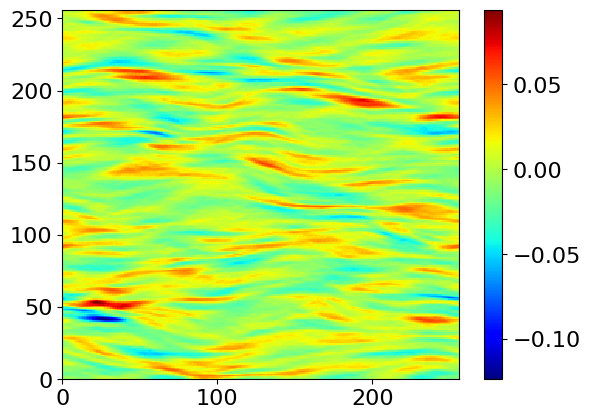

In [10]:
def calculate_curl(Bx, By, Bz, x, y, z):
    # 计算偏导数
    dBz_dy = np.gradient(Bz, y, axis=1)
    dBy_dz = np.gradient(By, z, axis=2)
    dBx_dz = np.gradient(Bx, z, axis=2)
    dBz_dx = np.gradient(Bz, x, axis=0)
    dBy_dx = np.gradient(By, x, axis=0)
    dBx_dy = np.gradient(Bx, y, axis=1)

    # 计算旋度
    curl_x = dBz_dy - dBy_dz
    curl_y = dBx_dz - dBz_dx
    curl_z = dBy_dx - dBx_dy

    return curl_x, curl_y, curl_z
# Bx, By, Bz = Q_3d['bx'][:,:,:,1], Q_3d['by'][:,:,:,1], Q_3d['bz'][:,:,:,1]
Jx, Jy, Jz = calculate_curl(Bx, By, Bz, x, y, z)
uix, uiy, uiz = Q_3d['uix'][:,:,:,1], Q_3d['uiy'][:,:,:,1], Q_3d['uiz'][:,:,:,1]
ex, ey, ez = Q_3d['ex'][:,:,:,1], Q_3d['ey'][:,:,:,1], Q_3d['ez'][:,:,:,1]
ex_prime = ex+uiy*Bz-uiz*By
ey_prime = ey-uix*Bz+uiz*Bx
ez_prime = ez+uix*By-uiy*Bx
J_dot_e_prime = Jx*ex_prime + Jy*ey_prime + Jz*ez_prime
J_dot_e = Jx*ex + Jy*ey + Jz*ez
J_dot_e_prime_parallel = Jz*ez_prime
pi_xx, pi_yy, pi_zz = Q_3d['pi-xx'][:,:,:,epoch],Q_3d['pi-yy'][:,:,:,epoch],Q_3d['pi-zz'][:,:,:,epoch]
ni = Q_3d['ni'][:,:,:,epoch]
Ti = (pi_xx+pi_yy+pi_zz)/3/ni
plt.pcolormesh(np.gradient(By,axis=0)[:,182,:],cmap='jet')
plt.colorbar()

In [16]:
C = 5
print(lambda_mat_B.shape)
print(lambda_mat_B[0,0,0,:])
sort_indices = np.argsort(np.abs(np.real(lambda_mat_B)),axis=3)
sort_indices_u = np.argsort(np.abs(np.real(lambda_mat_u)),axis=3)
print(sort_indices[0,0,0,:])
lambda_mat_B_sorted = np.take_along_axis(lambda_mat_B,sort_indices,axis=3)
lambda_mat_u_sorted = np.take_along_axis(lambda_mat_u,sort_indices_u,axis=3)
eig_vec_B_sorted = np.take_along_axis(eigen_vec_B,sort_indices[...,np.newaxis],axis=3)
eig_vec_u_sorted = np.take_along_axis(eigen_vec_u,sort_indices_u[...,np.newaxis],axis=3)
n_vec_B = np.cross(eig_vec_B_sorted[:,:,:,1,:],eig_vec_B_sorted[:,:,:,2,:],axis=3)
n_vec_u= np.cross(eig_vec_u_sorted[:,:,:,1,:],eig_vec_u_sorted[:,:,:,2,:],axis=3)
print(eig_vec_B_sorted.shape)
print(eig_vec_B_sorted[0,1,0,:,:],eigen_vec_B[0,1,0,:,:])
condition_B = (np.abs(np.imag(lambda_mat_B[:,:,:,0]))<1e-10) & (np.abs(np.imag(lambda_mat_B[:,:,:,1]))<1e-10) & (np.abs(np.imag(lambda_mat_B[:,:,:,2]))<1e-10)  & (np.abs(lambda_mat_B_sorted[:,:,:,1])>C*np.abs(lambda_mat_B_sorted[:,:,:,0])) & (np.real(lambda_mat_B_sorted[:,:,:,1]*lambda_mat_B_sorted[:,:,:,2])<0)
condition_u = (np.abs(np.imag(lambda_mat_u[:,:,:,0]))<1e-10) & (np.abs(np.imag(lambda_mat_u[:,:,:,1]))<1e-10) & (np.abs(np.imag(lambda_mat_u[:,:,:,2]))<1e-10)  & (np.abs(lambda_mat_u_sorted[:,:,:,1])>C*np.abs(lambda_mat_u_sorted[:,:,:,0])) & (np.real(lambda_mat_u_sorted[:,:,:,1]*lambda_mat_u_sorted[:,:,:,2])<0)
condition_plane = np.abs(np.sum(n_vec_B*n_vec_u,axis=3)/np.linalg.norm(n_vec_B,axis=3)/np.linalg.norm(n_vec_u,axis=3))>0.9
condition = np.where(condition_B & condition_u & condition_plane)
i_lst, j_lst, k_lst = list(zip(condition))
# lambda_mat_B_sorted[i_lst,j_lst,k_lst].shape
# print(lambda_mat_B_sorted[condition[0]][0])
# print(eigen_vec_B[condition[0]])
print(condition[0].shape)
i_right = 0
x_point_lst = []
lambda_1_lst, lambda_2_lst = [], []
eig_vec_b1_lst = []
eig_vec_b2_lst = []
delta_l = 3
cos_lambda_1z_lst = []
cos_lambda_2z_lst = []
cos_lambda_max_lst = []
cos_lambda_min_lst = []
Bz_total = Bz
from scipy.interpolate import RegularGridInterpolator
x = np.linspace(-32, 32, 256)
y = np.linspace(-32, 32, 256)
z = np.linspace(-32, 32, 256)
# interp_Bx = RegularGridInterpolator((x, y, z), Bx)
# interp_By = RegularGridInterpolator((x, y, z), By)
# interp_Bz = RegularGridInterpolator((x, y, z), Bz_total)
# interp_Ti = RegularGridInterpolator((x, y, z), Ti)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
u = np.linspace(-5, 5, 100)  # a0方向坐标
v = np.linspace(-5, 5, 100)  # b0方向坐标
U, V = np.meshgrid(u, v)
for i in range(len(condition[0])):
    # print(i)
    cos_lambda_1z = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:],[0,0,1])/np.linalg.norm(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:])
    cos_lambda_2z = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:],[0,0,1])/np.linalg.norm(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])
    cos_lambda_1z_lst.append(cos_lambda_1z)
    cos_lambda_2z_lst.append(cos_lambda_2z)
    cos_lambda_max_lst.append(max(np.abs(cos_lambda_1z),np.abs(cos_lambda_2z)))
    cos_lambda_min_lst.append(min(np.abs(cos_lambda_1z),np.abs(cos_lambda_2z)))

    # vec_1, vec_2 = np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:]), np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])
    # a0 = vec_1 / np.linalg.norm(vec_1)
    # b_perp = vec_2 - np.dot(vec_2, a0)*a0  # 施密特正交化
    # b0 = b_perp / np.linalg.norm(b_perp)
    # n = np.cross(vec_1, vec_2)
    # center = np.array([-32,-32,-32])+0.25*np.array([i_lst[0][i],j_lst[0][i],k_lst[0][i]])
    # R = (center + U[..., None]*a0 + V[..., None]*b0+32)%64-32 
    # Bx_proj = interp_Bx(R)
    # By_proj = interp_By(R)
    # Bz_proj = interp_Bz(R)
    # B = np.stack([Bx_proj, By_proj, Bz_proj], axis=-1)
    # B_plane = B - np.dot(B, n)[..., None]*n / np.linalg.norm(n)**2
    # B_u = np.dot(B_plane, a0)
    # B_v = np.dot(B_plane, b0)
    # u_near = np.linspace(-2, 2, 50)
    # v_naer = np.linspace(-2, 2, 50)
    # # print(interp_Bx(((center + u_near[0]*a0)+32)%64-32).shape)
    # for j in range(len(u_near)):
    #     bx_temp_1, by_temp_1, bz_temp_1 = interp_Bx(((center + u_near[0]*a0)+32)%64-32), interp_By(((center + u_near[0]*a0)+32)%64-32),interp_Bz(((center + u_near[0]*a0)+32)%64-32)
    #     b1_temp = np.dot([bx_temp_1, by_temp_1, bz_temp_1],vec_2)
    #     bx_temp_2, by_temp_2, bz_temp_2 = interp_Bx(((center + u_near[0]*a0)+32)%64-32), interp_By(((center + u_near[0]*a0)+32)%64-32),interp_Bz(((center + u_near[0]*a0)+32)%64-32)
    #     b2_temp = np.dot([bx_temp_2, by_temp_2, bz_temp_2],vec_1)
    #     if j==0:
    #         b1_temp_0 = b1_temp
    #         b2_temp_0 = b2_temp
    #     if np.sign(b1_temp)*np.sign(b1_temp_0)<0 and np.sign(b2_temp)*np.sign(b2_temp_0)<0:
    #         i_right += 1
    #         eig_vec_b1_lst.append(vec_1)
    #         eig_vec_b2_lst.append(vec_2)


    
    a_1,b_1,c_1 = find_nearest_lattice((int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])),list(np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])),delta_l)
    a_2,b_2,c_2 = find_nearest_lattice((int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])),list(-np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])),delta_l)
    a_3,b_3,c_3 = find_nearest_lattice((int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])),list(np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:])),delta_l)
    a_4,b_4,c_4 = find_nearest_lattice((int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])),list(-np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:])),delta_l)
    a_1,b_1,c_1 = a_1%256,b_1%256,c_1%256
    a_2,b_2,c_2 = a_2%256,b_2%256,c_2%256
    a_3,b_3,c_3 = a_3%256,b_3%256,c_3%256
    a_4,b_4,c_4 = a_4%256,b_4%256,c_4%256
    B1 = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:],[Bx[a_1,b_1,c_1],By[a_1,b_1,c_1],Bz_total[a_1,b_1,c_1]])
    B2 = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:],[Bx[a_2,b_2,c_2],By[a_2,b_2,c_2],Bz_total[a_2,b_2,c_2]])
    B3 = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:],[Bx[a_3,b_3,c_3],By[a_3,b_3,c_3],Bz_total[a_3,b_3,c_3]])
    B4 = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:],[Bx[a_4,b_4,c_4],By[a_4,b_4,c_4],Bz_total[a_4,b_4,c_4]])
    # print(B1,B2,B3,B4)
    if (B1*B2<0)&(B3*B4<0):
        i_right += 1
        eig_vec_b1_lst.append(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:])
        eig_vec_b2_lst.append(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])
        x_point_lst.append([i_lst[0][i],j_lst[0][i],k_lst[0][i]])
        lambda_1_lst.append(np.real(lambda_mat_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2]))
        lambda_2_lst.append(np.real(lambda_mat_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1]))
        print(i_right)
    # if (i%100==0):
        print("origin",(int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])))
        print("new",(a_1,b_1,c_1),r"$\vec{B}\cdot\hat{l}$=",np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],0,:],[Bx[a_1,b_1,c_1],By[a_1,b_1,c_1],Bz[a_1,b_1,c_1]]))
    # print(a,b,c)

# print(a)
# print(sort_indices.shape)


(256, 256, 256, 3)
[ 0.0207954 +0.02611271j  0.0207954 -0.02611271j -0.02466365+0.j        ]
[0 1 2]
(256, 256, 256, 3, 3)
[[ 0.56383371+0.j  0.74153161+0.j  0.90831314+0.j]
 [ 0.8224886 +0.j  0.3510482 +0.j  0.0869046 +0.j]
 [-0.07486023+0.j  0.57174823+0.j  0.40916356+0.j]] [[-0.07486023+0.j  0.57174823+0.j  0.40916356+0.j]
 [ 0.8224886 +0.j  0.3510482 +0.j  0.0869046 +0.j]
 [ 0.56383371+0.j  0.74153161+0.j  0.90831314+0.j]]
(66461,)
1
origin (0, 132, 51)
new (254, 134, 51) $\vec{B}\cdot\hat{l}$= (1.2528265983485245+0j)
2
origin (0, 234, 249)
new (255, 237, 249) $\vec{B}\cdot\hat{l}$= (1.089563627213282+0j)
3
origin (0, 235, 253)
new (255, 238, 253) $\vec{B}\cdot\hat{l}$= (1.0997212298502441+0j)
4
origin (2, 5, 249)
new (4, 3, 249) $\vec{B}\cdot\hat{l}$= (1.0222888667168808+0j)
5
origin (2, 234, 253)
new (1, 237, 253) $\vec{B}\cdot\hat{l}$= (1.0203558818256873+0j)
6
origin (4, 132, 54)
new (2, 134, 54) $\vec{B}\cdot\hat{l}$= (1.0248243440798972+0j)
7
origin (4, 143, 11)
new (1, 144, 

(283, 3)


Text(0, 0.5, 'Count')

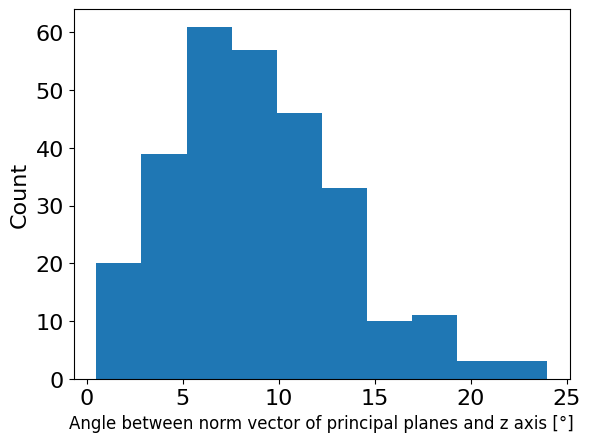

In [75]:
n_arr = np.cross(np.array(eig_vec_b1_lst),np.array(eig_vec_b2_lst), axis=1)
n_arr = n_arr/np.linalg.norm(n_arr,axis=1)[...,np.newaxis]
print(n_arr.shape)
# plt.hist(np.arccos(cos_lambda_max_lst)*180/np.pi, bins=np.linspace(0,90,50))
plt.hist(np.arccos(np.abs(n_arr[:,2]))*180/np.pi)
# plt.hist(cos_lambda_min_lst, bins=np.linspace(0,1,80))
plt.xlabel("Angle between norm vector of principal planes and z axis [°]", fontsize=12)
plt.ylabel("Count")

In [163]:
B_grad_matrix_lst = []
for i in range(75,76):
    center = np.array([-32,-32,-32])+0.25*np.array(x_point_lst[i])
    print(center)
    print(i)
    B_grad_matrix_lst.append(calc_gradient_matrix_with_muti_satellites(center, L_lst=[1,2,3]))


[-18.25  23.5   12.5 ]
75
[-18.25        23.55283122  12.57396896]
[-18.          23.55283122  12.57396896]
[-18.125       23.76933757  12.57396896]
[-18.125       23.625       12.77809311]
[-17.875       23.76933757  12.52293793]
[-18.375       23.76933757  12.52293793]
[-18.125       23.33632487  12.52293793]
[-18.125       23.625       12.93118622]
[-18.5         23.40849365  12.47190689]
[-17.75        23.40849365  12.47190689]
[-18.125       24.0580127   12.47190689]
[-18.125       23.625       13.08427933]


[-0.9892767 +0.j -0.02548386+0.j -0.143813  +0.j] [-0.71351643+0.j  0.69455186+0.j  0.09215216+0.j]
[-0.48930616+0.j  0.86450345+0.j -0.11494895+0.j] [-0.99936456+0.j -0.01894826+0.j -0.03019013+0.j]
0.1327486058727213 -0.09854298620556592
(0.14572608951987104+0j) (-0.13939790331659813+0j)
cos_angle:  (0.47855945312645287+0j) (0.9934726821125593+0j)
cos_angle:  (0.9389776734302913+0j) (0.6971203921780149+0j)
    


c:\Users\mrwwn\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, '$\\lambda_1$ calculated with mutiple satellites')

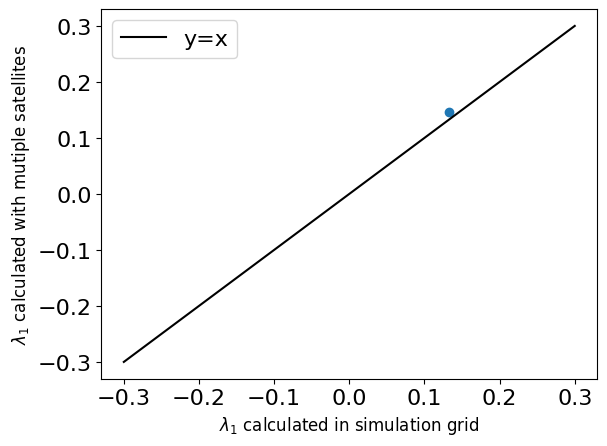

In [162]:
B_grad_matrix = np.array(B_grad_matrix_lst)
eigenvals, eigenvecs = calc_3x3_matrices_eigen(B_grad_matrix)
# eigenvals.shape
sort_indices = np.argsort(np.abs(np.real(eigenvals)),axis=1)
eigenvals_sorted = np.take_along_axis(eigenvals, sort_indices, axis=1)
eigenvecs_sorted = np.take_along_axis(eigenvecs, sort_indices[...,np.newaxis], axis=1)
eigenvecs_sorted_norm = eigenvecs_sorted/np.linalg.norm(eigenvecs_sorted,axis=2)[...,np.newaxis]
# print(eigenvals_sorted.shape)
# print(eigenvecs_sorted_norm[4,:,:])
eig_vec_b1_lst_multi_satellites = []
eig_val_b1_lst_multi_satellites = []
for i in range(len(eigenvals_sorted)):
    vec_1 = eig_vec_b1_lst[i]/np.linalg.norm(eig_vec_b1_lst[i])
    vec_2 = eig_vec_b2_lst[i]/np.linalg.norm(eig_vec_b2_lst[i])
    print(vec_1,vec_2)
    print(eigenvecs_sorted_norm[i,2,:],eigenvecs_sorted_norm[i,1,:])
    # print(np.abs(vec_1@eigenvecs_sorted_norm[i,:,:]))
    print(lambda_1_lst[i],lambda_2_lst[i])
    print(eigenvals_sorted[i,2],eigenvals_sorted[i,1])
    print("cos_angle: ",(np.dot(vec_1,eigenvecs_sorted_norm[i,2,:])),np.dot(vec_1,eigenvecs_sorted_norm[i,1,:]))
    print("cos_angle: ",(vec_2@eigenvecs_sorted_norm[i,2,:]),(vec_2@eigenvecs_sorted_norm[i,1,:]))
    # print("cos_angle: ",(vec_1@eigenvecs_sorted_norm[i,:,:].T)[2],(vec_1@eigenvecs_sorted_norm[i,:,:].T)[1])
    print("    ")
    index = np.argmax(np.abs(vec_1@eigenvecs_sorted_norm[i,:,:]))
    eig_vec_b1_lst_multi_satellites.append(eigenvecs_sorted_norm[i,index,:])
    eig_val_b1_lst_multi_satellites.append(eigenvals_sorted[i,index])


    
plt.scatter(lambda_1_lst[:len(eigenvals_sorted)], eig_val_b1_lst_multi_satellites)
plt.plot(np.linspace(-0.3,0.3,100),np.linspace(-0.3,0.3,100),label="y=x",color="k")
plt.legend()
plt.xlabel("$\lambda_1$ calculated in simulation grid", fontsize=12)
plt.ylabel("$\lambda_1$ calculated with mutiple satellites", fontsize=12)

[-0.432832   -0.74705167 -0.09425909] [-0.89417323  0.66450077  0.12859115]
(array([ 15,  29,  32,  37,  46,  62,  63,  65,  74,  78,  90,  91,  98,
       103, 127, 131, 140, 141, 142, 146, 148, 149, 153, 155, 161, 165,
       166, 169, 190, 209, 214, 221, 224, 226, 228, 244, 245, 246, 248,
       249, 251, 252, 259, 273, 276, 278, 279], dtype=int64),)
[-13.75  -1.25  -1.5 ]
(100, 101) (100, 101)


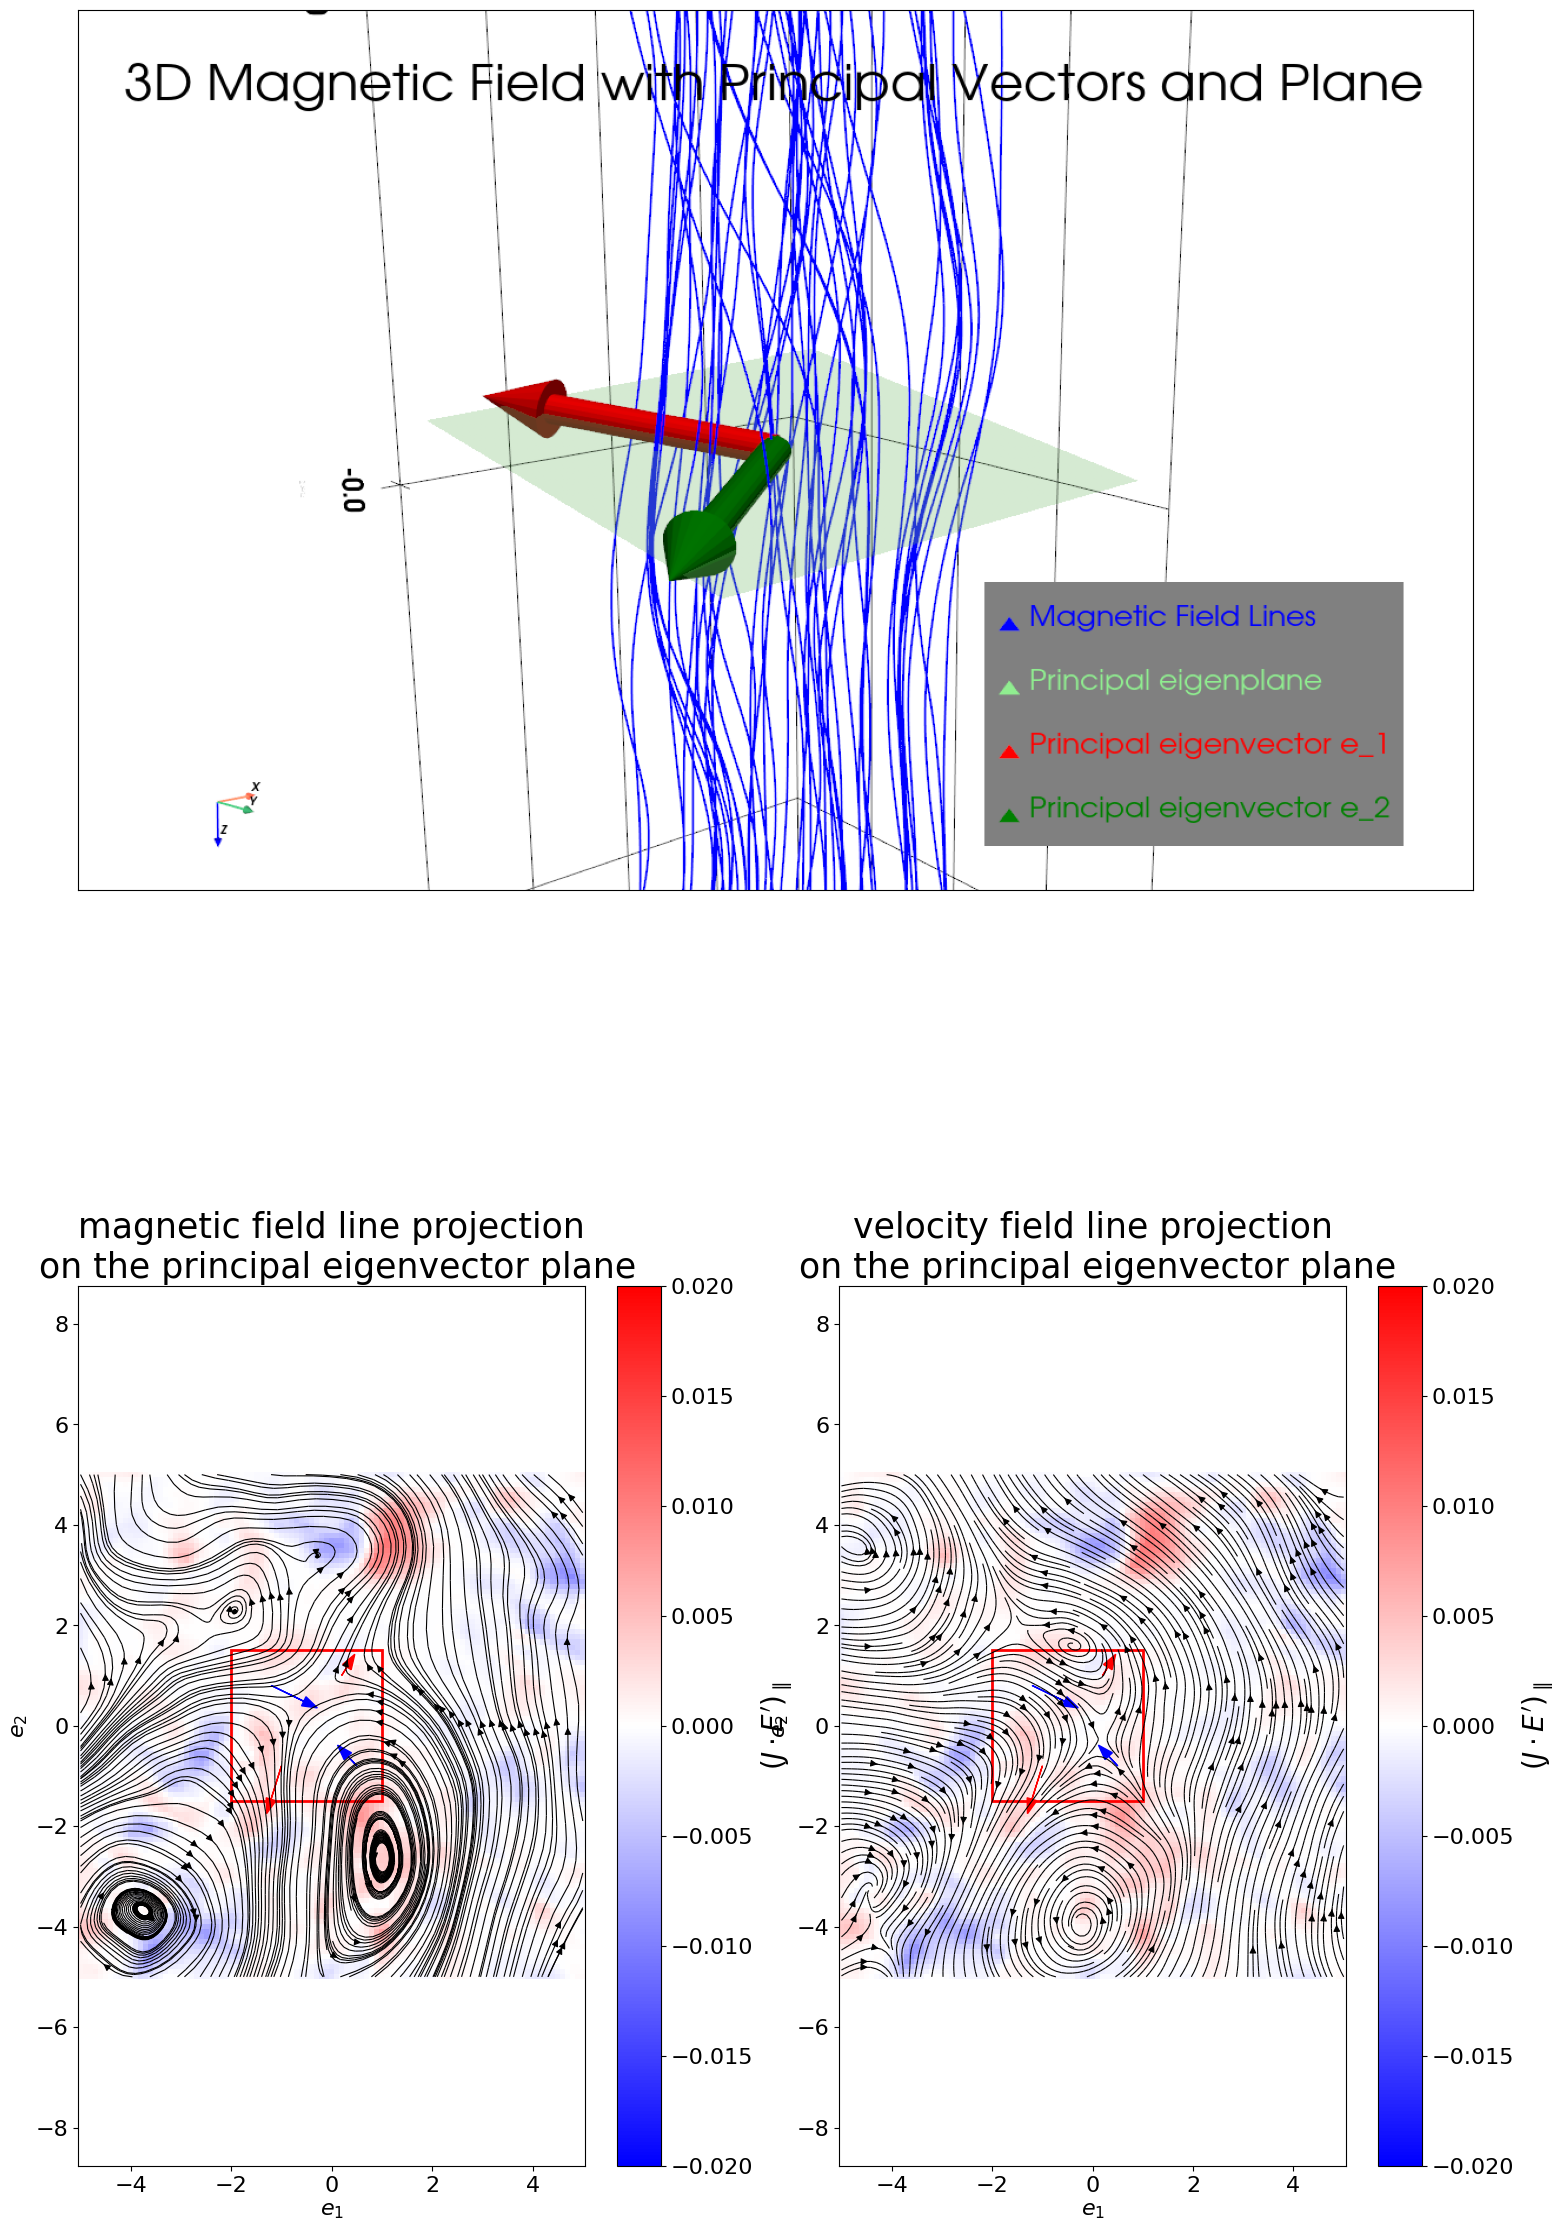

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from matplotlib.image import imread
i_plot = 90
a = np.array([1, 0, 0])  # 示例向量a
b = np.array([0, 1, 0])  # 示例向量b（此处为xy平面，可替换为任意不平行向量）
a = np.real(eig_vec_b1_lst[i_plot])
b = np.real(eig_vec_b2_lst[i_plot])
# a_prime = eigenvecs_sorted_norm[0,2,:]
# b_prime = eigenvecs_sorted_norm[0,1,:]
print(a,b)
# print(-32+0.25*np.array(x_point_lst[:][2]))
print(np.where((-32+0.25*np.array(x_point_lst)[:,2]>-5)&(-32+0.25*np.array(x_point_lst)[:,2]<5)))
center = np.array([-32,-32,-32])+0.25*np.array(x_point_lst[i_plot])
print(center)
# print(np.dot([Bx[i_lst[0][i],j_lst[0][i],k_lst[0][i]],By[i_lst[0][i],j_lst[0][i],k_lst[0][i]],Bz_total[i_lst[0][i],j_lst[0][i],k_lst[0][i]]],a))
a0 = a / np.linalg.norm(a)
b_perp = b - np.dot(b, a0)*a0  # 施密特正交化
b0 = b_perp / np.linalg.norm(b_perp)
n = np.cross(a, b)
from scipy.interpolate import RegularGridInterpolator

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
# 3. 构建目标平面（xy平面）的二维网格
u = np.linspace(-5, 5, 101)  # a0方向坐标

v = np.linspace(-5, 5, 100)  # b0方向坐标
u_near = np.linspace(-1.5, 1.5, 20)  # a0方向坐标
v_near = np.linspace(-1.5, 1.5, 20)  # b0方向坐标
U, V = np.meshgrid(u, v)
U_near, v_near = np.meshgrid(u_near, v_near)
# 将二维网格点映射到三维空间（xy平面，z=0）
R = (center + U[..., None]*a0 + V[..., None]*b0+32)%64-32  # R.shape = (100,100,3)
R_near = (center + U_near[..., None]*a0 + v_near[..., None]*b0+32)%64-32  # R.shape = (100,100,3)
# print(center,R)
# 4. 插值获取平面上的三维磁场并投影
# 构建三维插值器
interp_Bx = RegularGridInterpolator((x, y, z), Bx)
interp_By = RegularGridInterpolator((x, y, z), By)
interp_Bz = RegularGridInterpolator((x, y, z), Bz_total)
interp_uix = RegularGridInterpolator((x, y, z), uix)
interp_uiy = RegularGridInterpolator((x, y, z), uiy)
interp_uiz = RegularGridInterpolator((x, y, z), uiz)
interp_Ti = RegularGridInterpolator((x, y, z), Ti)
interp_J_dot_e_prime = RegularGridInterpolator((x, y, z), J_dot_e_prime)
interp_J_dot_e_prime_parallel = RegularGridInterpolator((x, y, z), J_dot_e_prime_parallel)
interp_J_dot_e = RegularGridInterpolator((x, y, z), J_dot_e)
# 插值得到平面上的B向量
Bx_proj = interp_Bx(R)
By_proj = interp_By(R)
Bz_proj = interp_Bz(R)
uix_proj = interp_uix(R)
uiy_proj = interp_uiy(R)
uiz_proj = interp_uiz(R)
Ti_proj = interp_Ti(R)
J_dot_e_prime_proj = interp_J_dot_e_prime(R)
J_dot_e_prime_parallel_proj = interp_J_dot_e_prime_parallel(R)
J_dot_e_proj = interp_J_dot_e(R)
uix_proj_near = interp_uix(R_near)
uiy_proj_near = interp_uiy(R_near)
uiz_proj_near = interp_uiz(R_near)

B = np.stack([Bx_proj, By_proj, Bz_proj], axis=-1)
ui = np.stack([uix_proj, uiy_proj, uiz_proj], axis=-1)
ui_near = np.stack([uix_proj_near, uiy_proj_near, uiz_proj_near], axis=-1)
# 剔除法向分量（n=(0,0,1)，此处即剔除Bz）
B_plane = B - np.dot(B, n)[..., None]*n / np.linalg.norm(n)**2
ui_plane = ui - np.dot(ui, n)[..., None]*n / np.linalg.norm(n)**2
ui_plane_near = ui_near - np.dot(ui_near, n)[..., None]*n / np.linalg.norm(n)**2
# 转化为局部二维分量（B_u = B·a0，B_v = B·b0）
B_u = np.dot(B_plane, a0)
B_v = np.dot(B_plane, b0)
u_u = np.dot(ui_plane, a0)
u_v = np.dot(ui_plane, b0)
u_u_near = np.dot(ui_plane_near, a0)
u_v_near = np.dot(ui_plane_near, b0)
u_u_prime = u_u-u_u_near.mean()
u_v_prime = u_v-u_v_near.mean()
rect = Rectangle(
    (-2, -1.5),  # 左下角坐标
    width=3,  # 沿x轴长度
    height=3,  # 沿y轴长度
    edgecolor='red',  # 边框颜色
    facecolor='none',  # 填充颜色（none为空心）
    linewidth=2,  # 边框线宽
    linestyle='-'  # 边框样式（虚线）
)
# 5. 绘制磁力线投影
fig = plt.figure(figsize=(18, 28))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], hspace=0.45)
ax = fig.add_subplot(gs[0, :])
ax.imshow(imread("screenshot_90.png"),aspect='auto')
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(gs[1,0])
ax.streamplot(U, V, B_u, B_v, density=1, color='k', linewidth=0.8, broken_streamlines=False)
print(u_u_prime.shape,u_v_prime.shape)
pclr = ax.pcolormesh(U,V,J_dot_e_prime_parallel_proj,cmap='bwr',shading='auto', vmin=-0.02, vmax=0.02)
cbar=plt.colorbar(pclr,ax=ax)
cbar.set_label(r'$(J\cdot E^\prime)_{\parallel}$', fontsize=20)
ax.arrow(-1.2,0.8,10*(u_u_prime[58,38]), 10*u_v_prime[58,38], head_width=0.2,color='b')
# ax.arrow(0.3,0,10*(u_u_prime[50,53]), 10*u_v_prime[50,53], head_width=0.2,color='b')
ax.arrow(0.2,1,10*(u_u_prime[60,52]), 10*u_v_prime[60,52], head_width=0.2, color='r')
ax.arrow(0.5,-0.8,10*(u_u_prime[42,55]), 10*u_v_prime[42,55], head_width=0.2, color='b')
ax.arrow(-1,-0.8,10*(u_u_prime[42,40]), 10*u_v_prime[40,42], head_width=0.2, color='r')
# ax.arrow(1.5,-0.3,10*(u_u_prime[50,65]), 10*u_v_prime[50,65], head_width=0.2, color='r')
# # ax.streamplot(U, V, u_u-u_u_near.mean(), u_v-u_v_near.mean(), density=2, color='b', linewidth=0.8)
# # plt.streamplot(U, V, u_u-u_u_near.mean(), u_v-u_v_near.mean(), density=2, color='b', linewidth=0.8)
ax.add_patch(rect)
ax.set_xlabel(f'$e_1$')
ax.set_ylabel(f'$e_2$')
ax.set_title(f'magnetic field line projection\n on the principal eigenvector plane', fontsize=25)
ax.axis('equal')
ax = fig.add_subplot(gs[1,1])
rect = Rectangle(
    (-2, -1.5),  # 左下角坐标
    width=3,  # 沿x轴长度
    height=3,  # 沿y轴长度
    edgecolor='red',  # 边框颜色
    facecolor='none',  # 填充颜色（none为空心）
    linewidth=2,  # 边框线宽
    linestyle='-'  # 边框样式（虚线）
)
# ax.streamplot(U, V, B_u, B_v, density=2, color='k', linewidth=0.8)
ax.streamplot(U, V, u_u-u_u_near.mean(), u_v-u_v_near.mean(), density=3, color='k', linewidth=0.8)
pclr = ax.pcolormesh(U,V,J_dot_e_prime_parallel_proj,cmap='bwr',shading='auto', vmin=-0.02, vmax=0.02)
cbar=plt.colorbar(pclr,ax=ax)
cbar.set_label(r'$(J\cdot E^\prime)_{\parallel}$', fontsize=20)
ax.arrow(-1.2,0.8,10*(u_u_prime[58,38]), 10*u_v_prime[58,38], head_width=0.2,color='b')
# ax.arrow(0.3,0,10*(u_u_prime[50,53]), 10*u_v_prime[50,53], head_width=0.2,color='b')
ax.arrow(0.2,1,10*(u_u_prime[60,52]), 10*u_v_prime[60,52], head_width=0.2, color='r')
ax.arrow(0.5,-0.8,10*(u_u_prime[42,55]), 10*u_v_prime[42,55], head_width=0.2, color='b')
ax.arrow(-1,-0.8,10*(u_u_prime[42,40]), 10*u_v_prime[40,42], head_width=0.2, color='r')
ax.add_patch(rect)
ax.set_xlabel(f'$e_1$')
ax.set_ylabel(f'$e_2$')
ax.set_title(f'velocity field line projection\n on the principal eigenvector plane', fontsize=25)
ax.axis('equal')
plt.show()

0
[-0.75546565 -0.01946087 -0.10982345] [-0.64528466  0.62813363  0.08333988]
[-32.     1.   -19.25]
1
[-0.95805754  0.47951505 -0.12013916] [-0.22606027  0.87740321 -0.03889034]
[-32.    26.5   30.25]
2
[-0.93978441  0.4494116  -0.10361007] [-0.26113885  0.89312681 -0.02436112]
[-32.    26.75  31.25]
3
[0.71552366 0.33509794 0.01713648] [ 0.63663594 -0.94170359 -0.16375087]
[-31.5  -30.75  30.25]
4
[-0.97236324  0.52418788 -0.11337649] [-0.14392727  0.84857532 -0.03444448]
[-31.5   26.5   31.25]
5
[-0.60102385 -0.42503721 -0.17523175] [-0.59510042  0.79630828  0.07422044]
[-31.    1.  -18.5]
6
[ 0.05164878 -0.84594472 -0.1474495 ] [-0.97522692  0.32571625  0.17405104]
[-31.     3.75 -29.25]
7
[-0.93025429 -0.71224203  0.12639223] [-0.13908357  0.69150168  0.03441117]
[-30.75 -25.25 -15.75]
8
[-0.70925471 -0.09297826  0.07343294] [-0.69687156  0.99533171 -0.16471847]
[-30.5 -25.   21. ]
9
[ 0.54623556 -0.36374166  0.02093174] [-0.77162446 -0.83947153 -0.01617914]
[-30.25  31.75  22.25]

Text(0, 0.5, 'Counts')

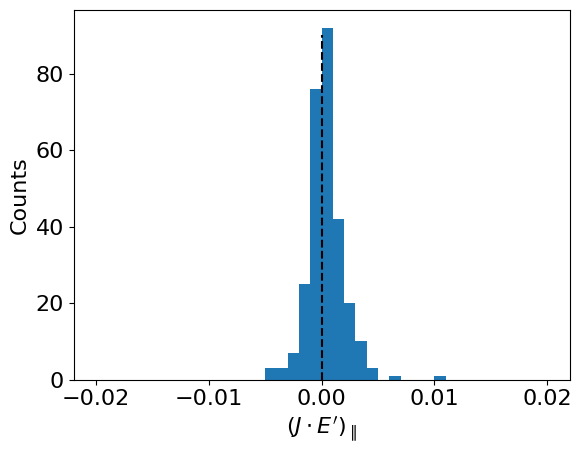

In [106]:
J_dot_e_prime_parallel_proj_near_lst = []
for i in range(len(x_point_lst)): #interpolate J_dot_e_prime_parallel
    print(i)
    a = np.real(eig_vec_b1_lst[i])
    b = np.real(eig_vec_b2_lst[i])
    # a_prime = eigenvecs_sorted_norm[0,2,:]
    # b_prime = eigenvecs_sorted_norm[0,1,:]
    print(a,b)
    center = np.array([-32,-32,-32])+0.25*np.array(x_point_lst[i])
    print(center)
    # print(np.dot([Bx[i_lst[0][i],j_lst[0][i],k_lst[0][i]],By[i_lst[0][i],j_lst[0][i],k_lst[0][i]],Bz_total[i_lst[0][i],j_lst[0][i],k_lst[0][i]]],a))
    a0 = a / np.linalg.norm(a)
    b_perp = b - np.dot(b, a0)*a0  # 施密特正交化
    b0 = b_perp / np.linalg.norm(b_perp)
    center = np.array([-32,-32,-32])+0.25*np.array(x_point_lst[i])
    u_near = np.linspace(-1.5, 1.5, 20)  # a0方向坐标
    v_near = np.linspace(-1.5, 1.5, 20)  # b0方向坐标
    U_near, V_near = np.meshgrid(u_near, v_near)  # U_near.shape = (100,100), v_near.shape = (100,100)
    R_near = (center + U_near[..., None]*a0 + v_near[..., None]*b0+32)%64-32  # R.shape = (100,100,3)
    J_dot_e_prime_parallel_proj_near = interp_J_dot_e_prime_parallel(R_near)
    # interp_J_dot_e_prime = RegularGridInterpolator((x, y, z), J_dot_e_prime)
# interp_J_dot_e_prime_parallel = RegularGridInterpolator((x, y, z), J_dot_e_prime_parallel)
# interp_J_dot_e = RegularGridInterpolator((x, y, z), J_dot_e)
    J_dot_e_prime_parallel_proj_near_lst.append(J_dot_e_prime_parallel_proj_near.mean())
plt.hist(J_dot_e_prime_parallel_proj_near_lst, bins=np.linspace(-0.02,0.02,41))
print(np.array(J_dot_e_prime_parallel_proj_near_lst).mean())
plt.plot([0,0],[0,90],'k--')
plt.xlabel('$(J\cdot E^\prime)_{\parallel}$')
plt.ylabel('Counts')

In [59]:
# import numpy as np
import pyvista as pv

# ----------------------沿用你的变量（确保以下变量已定义）----------------------
# x, y, z: 一维数组，通过 np.linspace(-32, 32, 256) 生成
# Bx, By, Bz_total: 三维数组，形状为 (256, 256, 256)
# a, b: 主特征向量
# center: 平面中心点

# 单位化主特征向量
a0 = a / np.linalg.norm(a)
b_perp = b - np.dot(b, a0) * a0
b0 = b_perp / np.linalg.norm(b_perp)
n = np.cross(a0, b0)  # 平面法向量


# ----------------------关键修改：正确创建三维网格----------------------
# 1. 用 meshgrid 生成三维坐标网格（与你的磁场数据维度匹配）
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')  # 形状均为 (256, 256, 256)

# 2. 创建结构化网格：指定点坐标和网格维度
grid = pv.StructuredGrid()
# 将三维坐标展平为 (N, 3) 形状的点坐标（N=256×256×256）
grid.points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
# 指定网格维度（必须与 x, y, z 的长度一致）
grid.dimensions = (len(x), len(y), len(z))  # (256, 256, 256)


# ----------------------正确添加磁场向量场----------------------
# 展平磁场分量并合并为向量场（形状为 (N, 3)，N=256³）
magnetic_field = np.stack([Bx.ravel(), By.ravel(), Bz_total.ravel()], axis=1)
# magnetic_field = np.stack([uix.ravel(), uiy.ravel(), uiz.ravel()], axis=1)
grid['magnetic_field'] = magnetic_field  # 此时点数量与向量场长度匹配


# ----------------------生成三维磁力线----------------------
# 种子点：在中心点附近生成（确保在网格范围内）
seed_points = pv.PointSet(
    center + np.random.rand(50, 3) * 10 - 5  # 中心点周围±5范围
)

# 生成磁力线
streamlines = grid.streamlines_from_source(
                seed_points,  # 使用包含卫星种子点的集合
                vectors="magnetic_field",
                max_time=700,  # 延长流线长度（确保穿过卫星）
                integration_direction="both",  # 双向积分（从卫星向前后延伸）
                max_steps=1000  # 增加步数，避免流线过早终止
            )


# ----------------------绘制主特征向量箭头----------------------
arrow_length = 8.0

# 向量a的箭头
arrow_a = pv.Arrow(
    start=center,
    direction=a* arrow_length,
    # tip_radius=0.01,
    # tip_length=1.0,
    # shaft_radius=0.15,
    scale=10
)

# 向量b的箭头
arrow_b = pv.Arrow(
    start=center,
    direction=b * arrow_length,
    # tip_radius=0.01,
    # tip_length=1.0,
    # shaft_radius=0.15,
    scale=10
)

# arrow_a_prime = pv.Arrow(
#     start=center,
#     direction=-a_prime* arrow_length,
#     # tip_radius=0.01,
#     # tip_length=1.0,
#     # shaft_radius=0.15,
#     scale=10
# )

# # 向量b的箭头
# arrow_b_prime = pv.Arrow(
#     start=center,
#     direction=-b_prime * arrow_length,
#     # tip_radius=0.01,
#     # tip_length=1.0,
#     # shaft_radius=0.15,
#     scale=10
# )
# arrow_b_prime_2 = pv.Actor(
#     mapper=pv.DataSetMapper(arrow_b_prime)  # 绑定箭头数据
# )

# 3. 通过Actor的Property设置虚线和线条粗细
# SetLineStyle(2)：2=虚线（1=实线，3=点线，4=点划线）
# vtk_actor = arrow_b_prime_2.GetVTKActor()  # 获取 VTK 原生 Actor
# vtk_prop = vtk_actor.GetProperty()  # 获取 VTK 原生属性对象（支持 SetLineStyle）

# # 4. 设置虚线和线条粗细（VTK 原生方法）
# vtk_prop.SetLineStyle(2)
# ----------------------绘制a和b张成的平面----------------------
plane_size = 15.0
plane = pv.Plane(
    center=center,
    direction= n,
    # direction_x=a0,
    # direction_y=b0,
    i_size=plane_size,
    j_size=plane_size,
    i_resolution=50,
    j_resolution=50
)
# plane['opacity'] = 0.3


# ----------------------可视化----------------------
p = pv.Plotter(window_size=[1200, 800])
p.add_mesh(streamlines, line_width=2, color='blue', label='Magnetic Field Lines')
p.add_mesh(plane, color='lightgreen', opacity=0.3, label='Principal eigenplane')
p.add_mesh(arrow_a, color='red', label=r'Principal eigenvector e_1')
p.add_mesh(arrow_b, color='green', label=r'Principal eigenvector e_2')
# p.add_mesh(arrow_b_prime, color=(1.0, 0.7, 0.7), label=r'Principal eigenvector(muti-satellites) e_2')
# p.add_mesh(arrow_a_prime, color=(0.7, 1.0, 0.7), label=r'Principal eigenvector(muti-satellites) e_1')
print(p.actors.keys())
# arrow_actor=p.actors['PolyData(Addr=000001CD5D858CD0)']

# 4. 通过VTK底层方法设置虚线（兼容旧版本的核心步骤）
# 获取VTK原生的属性对象（无论PyVista版本多旧，VTK底层一定支持）
# vtk_prop = arrow_actor.GetProperty()
# vtk_prop.SetLineStyle(2)
# p.add_points(center, color='yellow', point_size=30, label='Center')
p.add_axes()
p.add_title('3D Magnetic Field with Principal Vectors and Plane')
legend = p.add_legend(loc='lower right',size=(0.3, 0.3))
if hasattr(legend, 'GetLabelTextProperty'):
    label_prop = legend.GetLabelTextProperty()  # 全局条目文本属性
    label_prop.SetFontSize(26)
p.camera_position = [center + [30, 30, 30], center, n]  # 调整视角
p.show_grid()
p.show()
image_file = '3D_MagneticField.png'
image_3d = p.screenshot(image_file, transparent_background=False)

dict_keys(['PolyData(Addr=0000027FACA53420)', 'PolyData(Addr=00000282F2385830)', 'PolyData(Addr=00000282F2385980)', 'PolyData(Addr=0000027FACA53490)'])


Widget(value="<iframe src='http://localhost:50411/index.html?ui=P_0x2813f82aac0_1&reconnect=auto' style='width…

In [57]:

p = pv.Plotter(window_size=[1200, 800])
grid = pv.ImageData(dimensions=Bx.shape)
grid['bx'] = J_dot_e_prime_parallel.flatten()
point_set = -32*np.ones_like(np.array(x_point_lst))+np.array(x_point_lst)
# point_set.shape
p.add_points(point_set, color='red', point_size=10)
p.add_volume(
                grid,
                scalars='bx',
                cmap="jet",
                opacity=[0.01,0.01,0.5],

                # opacity=[0.005, 0.005],
                shade=True,
                # clim=[0.5, 2.5]
            )
p.show()

c:\Users\mrwwn\AppData\Local\Programs\Python\Python39\lib\site-packages\pyvista\core\utilities\points.py:52: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value="<iframe src='http://localhost:53150/index.html?ui=P_0x1a5ac0bd5e0_11&reconnect=auto' style='widt…

In [ ]:
fig = plt.figure(figsize=(23, 5.5))
plt.subplot(1, 3, 1)
B = Q_3d['bz']
x = np.linspace(0, Lx, nx)
z = np.linspace(0, Lz, nz)
plt.pcolor(x,z,B[:,0,:,4].T, cmap='hot')
plt.title(r'$\omega_{ci}t$ = 272')
plt.xlabel(r'x $[di]$')
plt.ylabel(r'z $[di]$')
plt.colorbar(label=r'$B_z /B_0$')

plt.subplot(1, 3, 2)
B = Q_3d['bz']
x = np.linspace(0, Lx, nx)
z = np.linspace(0, Lz, nz)
plt.pcolor(x,z,B[0,:,:,4].T, cmap='hot')
plt.title(r'$\omega_{ci}t$ = 272')
plt.xlabel(r'y $[di]$')
plt.ylabel(r'z $[di]$')
plt.colorbar(label=r'$B_z /B_0$')

plt.subplot(1, 3, 3)
B = Q_3d['bz']
x = np.linspace(0, Lx, nx)
z = np.linspace(0, Lz, nz)
plt.pcolor(x, z, B[:,:,0,4].T, cmap='hot')
plt.title(r'$\omega_{ci}t$ = 272')
plt.xlabel(r'x $[di]$')
plt.ylabel(r'y $[di]$')
plt.colorbar(label=r'$B_z /B_0$')

plt.savefig('bz_3D_slice.png', dpi=300, bbox_inches='tight')

In [ ]:
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)
tidx = 2
Bx = np.copy(Q_3d['bx'][:,:,0,tidx])
By = np.copy(Q_3d['by'][:,:,0,tidx])
# 计算磁场的偏导数
dBy_dx = np.gradient(By, x, axis=0)  # 对 x 求偏导
dBx_dy = np.gradient(Bx, y, axis=1)  # 对 y 求偏导

# 计算旋度
curl_z = (dBy_dx - dBx_dy)
# 可视化旋度
plt.figure(figsize=(8, 6))

plt.contourf(X, Y, curl_z.T, levels=50, cmap='hot')
plt.colorbar(label=r'$J_z$')
plt.xlabel('x [di]')
plt.ylabel('y [di]')
plt.xlim([0,64])
plt.ylim([0,64])
plt.title(r'$J_z$ in x-y Plane at $\omega_{ci}t$ = '+ str(tidx*68))
# plt.axis('equal')
plt.savefig(str(tidx*68)+'curl_Bz_2D_slice.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
x = np.linspace(0, Lx, nx)
z = np.linspace(0, Lz, nz)
X, Z = np.meshgrid(x, z)
tidx = 4
By = np.copy(Q_3d['by'][0,:,:,tidx])
Bz = np.copy(Q_3d['bz'][0,:,:,tidx])
# 计算磁场的偏导数
dBy_dz = np.gradient(By, z, axis=1)  # 对 x 求偏导
dBz_dy = np.gradient(Bz, y, axis=0)  # 对 y 求偏导

# 计算旋度
curl_x = (dBy_dz - dBz_dy)
# 可视化旋度
plt.figure(figsize=(8, 6))

plt.contourf(X, Z, curl_x.T, levels=50, cmap='hot')
plt.colorbar(label=r'$J_x$')
plt.xlabel('y [di]')
plt.ylabel('Z [di]')
plt.xlim([0,64])
plt.ylim([0,64])
plt.title(r'$J_x$ in y-z Plane at $\omega_{ci}t$ = '+ str(tidx*68))
# plt.axis('equal')
plt.savefig(str(tidx*68)+'curl_Bx_2D_slice.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from tqdm import tqdm

# --------- 单向磁力线追踪 ---------
def trace_fieldline_2D_single(start, ds=0.01, max_steps=1000, direction=1):
    path = [start]
    pos = np.array(start)
    for _ in range(max_steps):
        Bx_val = interp_Bx(pos[0], pos[1])[0][0]
        By_val = interp_By(pos[0], pos[1])[0][0]
        B = np.array([Bx_val, By_val])
        B_norm = np.linalg.norm(B)
        if B_norm < 1e-10:
            break
        pos = pos + direction * ds * B / B_norm
        if not (x[0] <= pos[0] <= x[-1] and y[0] <= pos[1] <= y[-1]):
            break
        path.append(pos.copy())
    return np.array(path)

# --------- 计算单方向 Q ---------
def compute_Q_direction(x_sample, y_sample, delta=0.01, direction=1):
    Q_map = np.zeros((len(x_sample), len(y_sample)))
    
    for i in tqdm(range(len(x_sample))):
        for j in range(len(y_sample)):
            pos0 = np.array([x_sample[i], y_sample[j]])

            # 两个扰动足点
            pos_dx = pos0 + np.array([delta, 0])
            pos_dy = pos0 + np.array([0, delta])

            line0 = trace_fieldline_2D_single(pos0, direction=direction)
            line_dx = trace_fieldline_2D_single(pos_dx, direction=direction)
            line_dy = trace_fieldline_2D_single(pos_dy, direction=direction)

            if len(line0) == 0 or len(line_dx) == 0 or len(line_dy) == 0:
                Q_map[i, j] = 0
                continue

            # 保证相同积分长度，取最短轨迹长度
            min_len = min(len(line0), len(line_dx), len(line_dy))
            end0 = line0[min_len-1]
            end_dx = line_dx[min_len-1]
            end_dy = line_dy[min_len-1]

            # 有限差分计算雅可比
            dX_dx = (end_dx[0] - end0[0]) / delta
            dY_dx = (end_dx[1] - end0[1]) / delta
            dX_dy = (end_dy[0] - end0[0]) / delta
            dY_dy = (end_dy[1] - end0[1]) / delta

            N2 = dX_dx**2 + dY_dx**2 + dX_dy**2 + dY_dy**2
            detD = dX_dx * dY_dy - dX_dy * dY_dx
            Q = N2 / (np.abs(detD) + 1e-12)
            Q_map[i, j] = Q

    return Q_map

# --------- 主控函数：双向追踪 + 叠加 Q ---------
def compute_Q_both_directions(x_sample, y_sample, delta=0.01):
    print("Calculating Q_forward...")
    Q_forward = compute_Q_direction(x_sample, y_sample, delta=delta, direction=1)
    print("Calculating Q_backward...")
    Q_backward = compute_Q_direction(x_sample, y_sample, delta=delta, direction=-1)
    return Q_forward + Q_backward


In [10]:
import numpy as np



x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
z = np.linspace(0, Lz, nz)

tidx = 2
Bx = np.copy(Q_3d['bx'][:,:,:,tidx])
By = np.copy(Q_3d['by'][:,:,:,tidx])
Bz = np.copy(Q_3d['bz'][:,:,:,tidx])
Jx, Jy, Jz = calculate_curl(Bx, By, Bz, x, y, z)
J_total = np.sqrt(Jx**2 + Jy**2 + Jz**2)


Vx = np.copy(Q_3d['uix'][:,:,:,tidx])
Vy = np.copy(Q_3d['uiy'][:,:,:,tidx])   
Vz = np.copy(Q_3d['uiz'][:,:,:,tidx])

T_para = np.copy(Q_3d['pi-zz'])
T_perp = np.copy(Q_3d['pi-xx']+Q_3d['pi-yy'])/2
T_total = np.copy(Q_3d['pi-xx']+Q_3d['pi-yy']+Q_3d['pi-zz'])/3

NameError: name 'calculate_curl' is not defined

In [ ]:
z_slice = 0
x_sample = np.linspace(0, Lx, nx//2)
y_sample = np.linspace(0, Ly, ny//2)
# --------- 构建插值器 ---------
interp_Bx = RectBivariateSpline(x, y, Bx[:,:,z_slice])
interp_By = RectBivariateSpline(x, y, By[:,:,z_slice])

Q_map = compute_Q_both_directions(x_sample, y_sample, delta=0.1)

# --------- 可视化Q-map ---------
X_sample, Y_sample = np.meshgrid(x_sample, y_sample, indexing='ij')

X, Y = np.meshgrid(x, y, indexing='ij')
plt.figure(figsize=(8, 6))
plt.contourf(X_sample, Y_sample, np.log10(Q_map+1), levels=50, cmap='plasma')
plt.colorbar(label=r'$log_{10}$(Q)')
plt.streamplot(X.T, Y.T, Bx[:,:,z_slice].T, By[:,:,z_slice].T, color='white', density=1.5, linewidth=0.5, arrowsize=1.5, arrowstyle='->')
plt.title("Q-map")
plt.xlabel("X")
plt.ylabel("Y")
# plt.axis('equal')
plt.savefig('Q_map_2D.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
X.shape, Y.shape, Bx.shape, By.shape

In [ ]:
X, Y = np.meshgrid(x, y, indexing='ij')
plt.figure(figsize=(8, 6))
plt.contourf(X_sample, Y_sample, np.log10(Q_map), levels=50, cmap='plasma',vmax=3,vmin=1)
plt.colorbar(label=r'$log_{10}$(Q)')
plt.streamplot(X.T, Y.T, Bx[:,:,z_slice].T, By[:,:,z_slice].T, color='white', density=3, linewidth=0.7, arrowsize=1.0, arrowstyle='->')
plt.title("Q-map")
plt.xlabel("X [di]")
plt.ylabel("Y [di]")
# plt.axis('equal')
plt.savefig('Q_map_2D.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
mask = (T_total[:,:,:,tidx] > 0.38)
plt.scatter(Jz[mask].flatten(), T_total[:,:,:,tidx][mask].flatten(), s=0.1, c='blue')
plt.xlabel(r'$J_z$')
plt.ylabel(r'$T_{total}$')

In [ ]:
# 计算二维直方图
hist, xedges, yedges = np.histogram2d(Jz[mask].flatten(), T_total[:,:,:,tidx][mask].flatten(), range=[[-0.4, 0.4], [0.39, 0.43]], bins=25,density=True)

# 创建网格
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

# 绘制等值线
plt.figure(figsize=(6, 6))
plt.scatter(Jz[mask].flatten(), T_total[:,:,:,tidx][mask].flatten(), s=0.1, c='blue')
plt.contour(X, Y, np.log10(hist.T), levels=[1.5, 1.8, 2.1, 2.4,], vmin=1.0, vmax=2.5,colors='black',linestyles='-')  # levels 表示等值线的数量
# plt.colorbar()
plt.xlim([-0.4, 0.4])
plt.xlabel(r'$J_z$')
plt.ylabel(r'$T_{total}$')
plt.grid(linestyle='--', linewidth=1.0, alpha=0.7)
# plt.title('Contour of 2D Histogram')
plt.title(r'$\omega_{ci}t$ = '+ str(tidx*68))
plt.show()

In [ ]:
mask = (T_total[:,:,0,tidx] < 0.38)
z_slice = 0
t_slice = 2
fig = plt.figure(figsize=(15, 5.5))

plt.subplot(1, 2, 1)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
z = np.linspace(0, Lz, nz)
plt.pcolor(x, z, T_total[:,:,z_slice,t_slice].T, cmap='hot')
plt.colorbar(label=r'T')
plt.contour(x, z, T_total[:,:,z_slice,t_slice].T, colors='green',levels=([0.38]),linewidths=3)
plt.title(r'$T_{total},\ \omega_{ci}t$ = 136')
plt.xlabel(r'x $[di]$')
plt.ylabel(r'y $[di]$')

# plt.subplot(1, 3, 2)
# X, Y = np.meshgrid(x, y, indexing='ij')
# plt.pcolor(x, y, Jz[:,:,z_slice].T, cmap='jet')
# plt.contour(x, z, T_total[:,:,z_slice,4].T,levels=([0.36]),colors='black')
# Bx = np.copy(Q_3d['bx'][:,:,z_slice,4])
# By = np.copy(Q_3d['by'][:,:,z_slice,4])
# # plt.streamplot(x.T, y.T, Bx.T, By.T, color='k', linewidth=1, density=2)
# plt.title(r'$J_{z},\ \omega_{ci}t$ = 272')
# plt.xlabel(r'x $[di]$')
# plt.ylabel(r'y $[di]$')

plt.subplot(1, 2, 2)
X, Y = np.meshgrid(x, y, indexing='ij')
Vx_plot = Vx[:,:,z_slice]
Vx_plot[mask] = np.nan  # 将满足条件的值设为 NaN
# plt.pcolor(x, y, Vx_plot.T, cmap='seismic')
plt.contourf(X_sample, Y_sample, np.log10(Q_map), levels=50, cmap='plasma',vmax=3,vmin=1)
plt.colorbar(label=r'$log_{10}$(Q)')

Bx = np.copy(Q_3d['bx'][:,:,z_slice,t_slice])
By = np.copy(Q_3d['by'][:,:,z_slice,t_slice])
plt.streamplot(x.T, y.T, Bx.T, By.T, color='white', linewidth=1, density=2)
plt.contour(x, z, T_total[:,:,z_slice,t_slice].T,levels=([0.38]),colors='green',linewidths=3)
plt.title(r'$Q_{map},\ \omega_{ci}t$ = 136')
plt.xlabel(r'x $[di]$')
plt.ylabel(r'y $[di]$')
plt.xlim([0,64])
plt.ylim([0,64])

# plt.subplot(1, 3, 3)
# X, Y = np.meshgrid(x, y, indexing='ij')
# Vy_plot = Vy[:,:,z_slice]
# # Vy_plot[mask] = np.nan  # 将满足条件的值设为 NaN
# plt.pcolor(x, y, Vy_plot.T, cmap='seismic')
# plt.contour(x, z, T_total[:,:,z_slice,t_slice].T,levels=([0.36]),colors='red')
# Bx = np.copy(Q_3d['bx'][:,:,z_slice,t_slice])
# By = np.copy(Q_3d['by'][:,:,z_slice,t_slice])
# plt.streamplot(x.T, y.T, Bx.T, By.T, color='k', linewidth=1, density=2)
# plt.title(r'$V_{y},\ \omega_{ci}t$ = 272')
# plt.xlabel(r'x $[di]$')
# plt.ylabel(r'y $[di]$')
# plt.xlim([20,40])
# plt.ylim([10,20])
plt.savefig('Q_map_turbulence_magnetic_reconnection.png', dpi=300, bbox_inches='tight')

In [ ]:
mask = (T_total[:,:,0,tidx] < 0.38)
z_slice = 0
t_slice = 2
fig = plt.figure(figsize=(15, 5.5))

plt.subplot(1, 2, 1)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
z = np.linspace(0, Lz, nz)
plt.pcolor(x, z, T_total[:,:,z_slice,t_slice].T, cmap='hot')
plt.colorbar(label=r'T')
plt.contour(x, z, T_total[:,:,z_slice,t_slice].T, colors='green',levels=([0.38]),linewidths=3)
plt.title(r'$T_{total},\ \omega_{ci}t$ = 136')
plt.xlabel(r'x $[di]$')
plt.ylabel(r'y $[di]$')
plt.xlim([40,50])
plt.ylim([48,60])
# plt.subplot(1, 3, 2)
# X, Y = np.meshgrid(x, y, indexing='ij')
# plt.pcolor(x, y, Jz[:,:,z_slice].T, cmap='jet')
# plt.contour(x, z, T_total[:,:,z_slice,4].T,levels=([0.36]),colors='black')
# Bx = np.copy(Q_3d['bx'][:,:,z_slice,4])
# By = np.copy(Q_3d['by'][:,:,z_slice,4])
# # plt.streamplot(x.T, y.T, Bx.T, By.T, color='k', linewidth=1, density=2)
# plt.title(r'$J_{z},\ \omega_{ci}t$ = 272')
# plt.xlabel(r'x $[di]$')
# plt.ylabel(r'y $[di]$')

plt.subplot(1, 2, 2)
X, Y = np.meshgrid(x, y, indexing='ij')
Vx_plot = Vx[:,:,z_slice]
Vx_plot[mask] = np.nan  # 将满足条件的值设为 NaN
# plt.pcolor(x, y, Vx_plot.T, cmap='seismic')
plt.contourf(X_sample, Y_sample, np.log10(Q_map), levels=50, cmap='plasma',vmax=3,vmin=1)
plt.colorbar(label=r'$log_{10}$(Q)')

Bx = np.copy(Q_3d['bx'][:,:,z_slice,t_slice])
By = np.copy(Q_3d['by'][:,:,z_slice,t_slice])
plt.streamplot(x.T, y.T, Bx.T, By.T, color='white', linewidth=1.5, density=3)
plt.contour(x, z, T_total[:,:,z_slice,t_slice].T,levels=([0.38]),colors='green',linewidths=3)
plt.title(r'$Q_{map},\ \omega_{ci}t$ = 136')
plt.xlabel(r'x $[di]$')
plt.ylabel(r'y $[di]$')
plt.xlim([40,50])
plt.ylim([48,60])

# plt.subplot(1, 3, 3)
# X, Y = np.meshgrid(x, y, indexing='ij')
# Vy_plot = Vy[:,:,z_slice]
# # Vy_plot[mask] = np.nan  # 将满足条件的值设为 NaN
# plt.pcolor(x, y, Vy_plot.T, cmap='seismic')
# plt.contour(x, z, T_total[:,:,z_slice,t_slice].T,levels=([0.36]),colors='red')
# Bx = np.copy(Q_3d['bx'][:,:,z_slice,t_slice])
# By = np.copy(Q_3d['by'][:,:,z_slice,t_slice])
# plt.streamplot(x.T, y.T, Bx.T, By.T, color='k', linewidth=1, density=2)
# plt.title(r'$V_{y},\ \omega_{ci}t$ = 272')
# plt.xlabel(r'x $[di]$')
# plt.ylabel(r'y $[di]$')
# plt.xlim([20,40])
# plt.ylim([10,20])
plt.savefig('sub_Q_map_turbulence_magnetic_reconnection.png', dpi=300, bbox_inches='tight')

In [ ]:

# --------- 采样网格 ---------
x_sample = np.linspace(-0.8, 0.8, 50)
y_sample = np.linspace(-0.8, 0.8, 50)

# --------- 定义二维网格与磁场 ---------
nx, ny = 100, 100
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# 示例：标准 X-point 磁场
k = 1.0
Bx = k * Y
By = k * X

# --------- 构建插值器 ---------
interp_Bx = RectBivariateSpline(x, y, Bx)
interp_By = RectBivariateSpline(x, y, By)

Q_map = compute_Q_both_directions(x_sample, y_sample, delta=0.02)

# --------- 可视化Q-map ---------
X_sample, Y_sample = np.meshgrid(x_sample, y_sample, indexing='ij')


In [ ]:
plt.figure(figsize=(8, 6))
plt.contourf(X_sample, Y_sample, np.log10(Q_map), levels=50, cmap='plasma')
plt.colorbar(label=r'$log_{10}$(Q)')
plt.streamplot(X.T, Y.T, Bx.T, By.T, color='white')

plt.title("Q-map")
plt.xlim([-0.8, 0.8])
plt.ylim([-0.8, 0.8])
plt.xlabel("X")
plt.ylabel("Y")
# plt.axis('equal')
plt.savefig('test_Q_map_2D.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nx, ny = 99, 100
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# 示例：标准 X-point 磁场
k = 1.0
Bx = k * Y
By = k * X

# 可视化磁力线
plt.figure(figsize=(8, 8))
plt.streamplot(X.T, Y.T, Bx.T, By.T, cmap='plasma')
plt.colorbar(label="|B|")
plt.title("2D Magnetic Field Lines (X-point)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()


In [ ]:
X.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

w = 3
x = np.linspace(-w, w, 100)
y = np.linspace(-w, w, 100)
Y,X = np.meshgrid(y, x,indexing='ij')
# Y, X = np.mgrid[-w:w:100j, -w:w:100j]
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2)

fig, axs = plt.subplots(3, 2, figsize=(7, 9), height_ratios=[1, 1, 2])
axs = axs.flat

#  Varying density along a streamline
axs[0].streamplot(X, Y, U, V, density=[0.5, 1])
axs[0].set_title('Varying Density')

# Varying color along a streamline
strm = axs[1].streamplot(X, Y, U, V, color=U, linewidth=2, cmap='autumn')
fig.colorbar(strm.lines)
axs[1].set_title('Varying Color')

#  Varying line width along a streamline
lw = 5*speed / speed.max()
axs[2].streamplot(X, Y, U, V, density=0.6, color='k', linewidth=lw)
axs[2].set_title('Varying Line Width')

# Controlling the starting points of the streamlines
seed_points = np.array([[-2, -1, 0, 1, 2, -1], [-2, -1,  0, 1, 2, 2]])

strm = axs[3].streamplot(X, Y, U, V, color=U, linewidth=2,
                         cmap='autumn', start_points=seed_points.T)
fig.colorbar(strm.lines)
axs[3].set_title('Controlling Starting Points')

# Displaying the starting points with blue symbols.
axs[3].plot(seed_points[0], seed_points[1], 'bo')
axs[3].set(xlim=(-w, w), ylim=(-w, w))

# Create a mask
mask = np.zeros(U.shape, dtype=bool)
mask[40:60, 40:60] = True
U[:20, :20] = np.nan
U = np.ma.array(U, mask=mask)

axs[4].streamplot(X, Y, U, V, color='r')
axs[4].set_title('Streamplot with Masking')

axs[4].imshow(~mask, extent=(-w, w, -w, w), alpha=0.5, cmap='gray',
              aspect='auto')
axs[4].set_aspect('equal')

axs[5].streamplot(X, Y, U, V, broken_streamlines=False)
axs[5].set_title('Streamplot with unbroken streamlines')

plt.tight_layout()
plt.show()

**以下无用**

In [ ]:
fig = plt.figure(figsize=(23, 5.5))
plt.subplot(1, 3, 1)
T_para = np.copy(Q_3d['pi-zz'])
T_perp = np.copy(Q_3d['pi-xx']+Q_3d['pi-yy'])/2
T_total = np.copy(Q_3d['pi-xx']+Q_3d['pi-yy']+Q_3d['pi-zz'])/3
mask = (T_total < 0.34)
T_total[mask] = np.nan
x = np.linspace(0, Lx, nx)
z = np.linspace(0, Lz, nz)
plt.pcolor(x, z, T_total[:,:,0,4], cmap='hot',vmin=0.3, vmax=0.425)
plt.title(r'$T_{total},\ t\omega_{ci}^{-1}$ = 272')
plt.xlabel(r'x $[di]$')
plt.ylabel(r'y $[di]$')
plt.colorbar(label=r'$B_z /B_0$')

plt.subplot(1, 3, 2)
B = np.copy(Q_3d['uix'])
B[mask] = 0.0
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
plt.pcolor(x, y, B[:,:,0,4], cmap='seismic', vmin=-0.2, vmax=0.2)
plt.streamplot(X, Y, Bx, By, color='k', linewidth=1, density=2)
plt.title(r'$V_{x},\ t\omega_{ci}^{-1}$ = 272')
plt.xlabel(r'x $[di]$')
plt.ylabel(r'y $[di]$')
plt.colorbar(label=r'$V_x$')

plt.subplot(1, 3, 3)
B = np.copy(Q_3d['uiy'])
B[mask] = 0.0
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
plt.contourf(X, Y, curl_z, levels=50, cmap='RdBu_r')
# plt.pcolor(x, y, B[:,:,10,4], cmap='seismic', vmin=-0.2, vmax=0.2)
plt.streamplot(X, Y, Bx, By, color='k', linewidth=1, density=2)

plt.title(r'$|J_{z}|,\ t\omega_{ci}^{-1}$ = 272')
plt.xlabel(r'x $[di]$')
plt.ylabel(r'y $[di]$')
plt.colorbar(label=r'$|J_z|$')

plt.savefig('turbulence_magnetic_reconnection.png', dpi=300, bbox_inches='tight')

In [ ]:
T_temp = np.copy(T_total[:,:,0,4])
mask = (T_temp > 0.0)
plt.scatter(np.abs(curl_z)[mask], T_temp[mask],s=4, c='k')
plt.xlabel(r'$|J_z|$')
plt.ylabel(r'$T_{total}$')

In [ ]:
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)
Bx = np.copy(Q_3d['bx'][:,:,0,4])
By = np.copy(Q_3d['by'][:,:,0,4])
# 绘制磁力线
plt.figure(figsize=(8, 8))
plt.streamplot(X, Y, Bx, By, color='k', linewidth=1, density=2)
plt.xlabel('x [di]')
plt.ylabel('y [di]')
plt.title('Magnetic Field Lines in x-y Plane')
plt.colorbar(label='Magnetic Field Strength')
plt.axis('equal')
plt.show()

In [ ]:
# 可视化
plt.figure(figsize=(8, 6))
P2D[P2D<10**(-1)] = 0.0
plt.contourf(kpara,kperp,np.log10(P2D),cmap='hot_r',levels=50,vmin=-1, vmax=9)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.3e-1, 1e1])
plt.ylim([1.9e-1, 1e1])
plt.xlabel('$k_\\parallel d_i$')
plt.ylabel('$k_\\perp d_i$')
plt.title('$PSD_{B_{trace}}(k_\\parallel, k_\\perp)$')
plt.colorbar()
plt.savefig('2D_spectrum.png', dpi=300)


plt.figure(figsize=(8, 6))
# plt.loglog(kperp, 1e5*kperp**(-4),label='$k^{-5/3}$',color='black', linestyle=':')
plt.loglog(kperp, 5e4*kperp**(-5/3),label='$k^{-5/3}$',color='black', linestyle=':')
plt.loglog(kperp, 3e2*kperp**(-3),label='$k^{-3}$',color='black', linestyle='--')
plt.loglog(kperp, P1D_perp, label='$P_{1D}(k_\\perp)$',color='black')
plt.loglog(kpara, P1D_para, label='$P_{1D}(k_\\parallel)$',color='red')
plt.xlabel(r'$k d_i$')
plt.ylabel(r'$PSD_{B_{trace}}$')
plt.legend()
plt.grid(True)
plt.title('$PSD_{B_{trace}}$')
plt.savefig(r'$B$ 1D_spectra.png', dpi=300)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设有一个3D傅里叶谱数据 P3D(kx, ky, kz)
# 这里构造一个测试用的3D能谱，比如各向同性Kolmogorov谱 ~ k^-11/3
def generate_test_spectrum(N):
    kx = np.fft.fftfreq(N)
    ky = np.fft.fftfreq(N)
    kz = np.fft.fftfreq(N)
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    k = np.sqrt(KX**2 + KY**2 + KZ**2)
    P3D = np.where(k > 0, k**(-11/3), 0.0)
    return P3D, kx, ky, kz

def compute_2D_spectrum(P3D, kx, ky, kz, nbins=50):
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    k_perp = np.sqrt(KX**2 + KY**2)
    k_para = np.abs(KZ)

    kperp_bins = np.linspace(0, np.max(k_perp), nbins + 1)
    kpara_bins = np.linspace(0, np.max(k_para), nbins + 1)
    P2D = np.zeros((nbins, nbins))

    for i in range(P3D.shape[0]):
        for j in range(P3D.shape[1]):
            for k in range(P3D.shape[2]):
                kp = k_perp[i, j, k]
                ka = k_para[i, j, k]
                p = P3D[i, j, k]
                bin_kp = np.digitize(kp, kperp_bins) - 1
                bin_ka = np.digitize(ka, kpara_bins) - 1
                if 0 <= bin_kp < nbins and 0 <= bin_ka < nbins:
                    P2D[bin_kp, bin_ka] += p

    kperp_centers = 0.5 * (kperp_bins[:-1] + kperp_bins[1:])
    kpara_centers = 0.5 * (kpara_bins[:-1] + kpara_bins[1:])
    return P2D, kperp_centers, kpara_centers

def compute_1D_spectra(P2D):
    P1D_perp = np.sum(P2D, axis=1)
    P1D_para = np.sum(P2D, axis=0)
    return P1D_perp, P1D_para

# 主程序
N = 92
P3D, kx, ky, kz = generate_test_spectrum(N)
P2D, kperp, kpara = compute_2D_spectrum(P3D, kx, ky, kz)
P1D_perp, P1D_para = compute_1D_spectra(P2D)

# 可视化
plt.figure()
plt.loglog(kperp, P1D_perp, label='$P_{1D,\\perp}(k_\\perp)$')
# plt.loglog(kpara, P1D_para, label='$P_{1D,\\parallel}(k_\\parallel)$')
plt.xlabel('Wavenumber')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.title('1D Spectra')

plt.show()


In [122]:
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
z = np.linspace(0, Lz, nz)
dx = Lx/nx
dy = Ly/ny
dz = Lz/nz
dt = 2.56
epoch = 3
bx_data, by_data, bz_data = Q_3d['bx'][:,:,:,epoch], Q_3d['by'][:,:,:,epoch], Q_3d['bz'][:,:,:,epoch]
ex_data, ey_data, ez_data = Q_3d['ex'][:,:,:,epoch], Q_3d['ey'][:,:,:,epoch], Q_3d['ez'][:,:,:,epoch]
# Jx_data, Jy_data, Jz_data = calculate_curl(bx_data, by_data, bz_data, x, y, z)
# bx_data, by_data, bz_data = np.load("非平衡AWturb数据/Bx.npy"),np.load("非平衡AWturb数据/By.npy"),np.load("非平衡AWturb数据/Bz.npy")
# ex_data, ey_data, ez_data = np.load("非平衡AWturb数据/Ex.npy"),np.load("非平衡AWturb数据/Ey.npy"),np.load("非平衡AWturb数据/Ez.npy")
Jx_data, Jy_data, Jz_data = calculate_curl(bx_data, by_data, bz_data, x, y, z)
# print(bx_data.shape)
FS_bx, FS_by, FS_bz = scipy.fft.fftn(bx_data, axes=(0,1,2)), scipy.fft.fftn(by_data, axes=(0,1,2)), scipy.fft.fftn(bz_data, axes=(0,1,2))
# print(FS_bx.size)
FS_Jx, FS_Jy, FS_Jz = (scipy.fft.fftn(Jx_data, axes=(0,1,2))), (scipy.fft.fftn(Jy_data, axes=(0,1,2))), (scipy.fft.fftn(Jz_data, axes=(0,1,2)))
FS_ex, FS_ey, FS_ez = (scipy.fft.fftn(ex_data, axes=(0,1,2))), (scipy.fft.fftn(ey_data, axes=(0,1,2))), (scipy.fft.fftn(ez_data, axes=(0,1,2)))
JdotE = np.real((FS_ex*np.conj(FS_Jx) + FS_ey*np.conj(FS_Jy) + FS_ez*np.conj(FS_Jz)+np.conj(FS_ex)*FS_Jx + np.conj(FS_ey)*FS_Jy + np.conj(FS_ez)*FS_Jz))/FS_ex.size/dx/dy/dz
JdotE_perp = np.real(FS_ex*np.conj(FS_Jx)+np.conj(FS_ex)*FS_Jx+FS_ey*np.conj(FS_Jy)+np.conj(FS_ey)*FS_Jy)/FS_ex.size/dx/dy/dz
JdotE_para = np.real(FS_ez*np.conj(FS_Jz)+np.conj(FS_ez)*FS_Jz)/FS_ex.size/dx/dy/dz
#print(np.abs(FS_bx[:,1,1]))

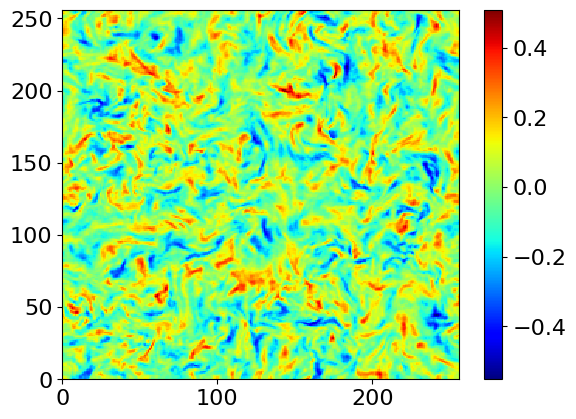

In [140]:
plt.pcolormesh(Jz[:,:,50].T, cmap='jet')
plt.colorbar()

In [ ]:
b_data = np.sqrt(bx_data**2+by_data**2+bz_data**2)

# print(np.min(gamma))
Pb = get_psd(b_data,dx,dy,dz)
Pb_trace = get_psd(bx_data,dx,dy,dz)+get_psd(by_data,dx,dy,dz)+get_psd(bz_data,dx,dy,dz)
gamma = -JdotE/2/Pb
# print(np.sum(JdotE[:,:,128]))
N = 256
print(FS_ex.shape)

kx = 2*np.pi*np.fft.fftfreq(N, dx)
ky = 2*np.pi*np.fft.fftfreq(N, dx)
kz = 2*np.pi*np.fft.fftfreq(N, dx)
JdotE_2D, kperp_centers, kpara_centers=compute_2D_spectrum(JdotE,kx,ky,kz, nbins=50)
JdotE_perp_2D, kperp_centers, kpara_centers=compute_2D_spectrum(JdotE_perp,kx,ky,kz, nbins=50)
JdotE_para_2D, kperp_centers, kpara_centers=compute_2D_spectrum(JdotE_para,kx,ky,kz, nbins=50)
PB_2D, kperp_centers, kpara_centers=compute_2D_spectrum(Pb,kx,ky,kz, nbins=50)
# PB_trace_2D, kperp_centers, kpara_centers=compute_2D_spectrum(Pb_trace,kx,ky,kz, nbins=50)
# gamma_2D, kperp_centers, kpara_centers=compute_2D_spectrum(gamma,kx,ky,kz, nbins=50)
# KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')



In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))
ax = axes[0]
pclr=ax.pcolormesh(kpara_centers, kperp_centers, (JdotE_para_2D), cmap='bwr', norm=matplotlib.colors.SymLogNorm(linthresh=1e5/FS_ex.size/dx**3, linscale=0.01, vmin=-2e5, vmax=2e5))
ax.set_ylim([0,10])
ax.set_xlim([0,10])
# ax.set_xscale('log')
# ax.set_yscale('log')
cbar=plt.colorbar(pclr,ax=ax)
ax.set_xlabel(r'$k_{\parallel}d_i$', fontsize=20)
ax.set_ylabel(r'$k_{\perp}d_i$', fontsize=20)
ax.set_title(r'$(J^*E+JE^*)_{\parallel}/(m_iv_A^3/d_i)$')
cbar.set_ticks(np.concatenate((-np.logspace(5,0,6),np.array([0]),np.logspace(0,5,6))))

ax = axes[1]
pclr=ax.pcolormesh(kpara_centers, kperp_centers, (JdotE_perp_2D), cmap='bwr', norm=matplotlib.colors.SymLogNorm(linthresh=1e5/FS_ex.size/dx**3, linscale=0.01, vmin=-2e5, vmax=2e5))
ax.set_ylim([0,10])
ax.set_xlim([0,10])
# ax.set_xscale('log')
# ax.set_yscale('log')
cbar=plt.colorbar(pclr,ax=ax)
ax.set_ylabel(r'$k_{\perp}d_i$', fontsize=20)
ax.set_xlabel(r'$k_{\parallel}d_i$', fontsize=20)
ax.set_title(r'$(J^*E+JE^*)_{\perp}/(m_iv_A^3/d_i)$')
cbar.set_ticks(np.concatenate((-np.logspace(5,0,6),np.array([0]),np.logspace(0,5,6))))

ax = axes[2]
pclr=ax.pcolormesh(kpara_centers, kperp_centers, (JdotE_2D), cmap='bwr', norm=matplotlib.colors.SymLogNorm(linthresh=1e5/FS_ex.size/dx**3, linscale=0.01, vmin=-2e5, vmax=2e5))
ax.set_ylim([0,10])
ax.set_xlim([0,10])
# ax.set_xscale('log')
# ax.set_yscale('log')
cbar=plt.colorbar(pclr,ax=ax)
ax.set_xlabel(r'$k_{\parallel}d_i$', fontsize=20)
ax.set_ylabel(r'$k_{\perp}d_i$', fontsize=20)
ax.set_title(r'$(J^*E+JE^*)/(m_iv_A^3/d_i)$')
cbar.set_ticks(np.concatenate((-np.logspace(5,0,6),np.array([0]),np.logspace(0,5,6))))
# cbar.set_ticklabels(np.concatenate((-np.logspace(5,0,5),np.logspace(0,5,5))))

# ax = axes[1]
# pclr=ax.pcolormesh(kpara_centers, kperp_centers, np.log10(PB_2D), cmap='jet')
# ax.set_xlabel(r'$k_{\parallel}d_i$', fontsize=20)
# ax.set_ylabel(r'$k_{\perp}d_i$', fontsize=20)
# ax.set_ylim([0,10])
# ax.set_xlim([0,10])
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([0,20])
# # ax.set_xlim([0,20])
# ax.set_title(r'$\log_{10}[E_B/(m_iv_A^3/d_i)]$')
# plt.colorbar(pclr,ax=ax)

# ax = axes[2]
# alpha = np.where((np.log10(np.abs(PB_2D))-np.log10(np.abs(PB_2D)).min())/(np.log10(np.abs(PB_2D)).max()-np.log10(np.abs(PB_2D)).min())>0.5,1, 0.3)
# print(alpha[2,40])
# print(((JdotE_2D)/PB_2D/8)[0,12])
# pclr=ax.pcolormesh(kpara_centers, kperp_centers, -(JdotE_2D)/PB_2D/8*1, cmap='bwr', norm=matplotlib.colors.SymLogNorm(linthresh=1e4/FS_ex.size/dx**3/40, linscale=0.01, vmin=-10, vmax=10),alpha=alpha )
# ax.set_xlabel(r'$k_{\parallel}d_i$', fontsize=20)
# ax.set_ylabel(r'$k_{\perp}d_i$', fontsize=20)
# ax.set_ylim([0,10])
# ax.set_xlim([0,10])
# # plt.colorbar(pclr,ax=ax)
# ax.set_title(r'$\gamma=-\frac{J^*E+JE^*}{8W_B}$')
plt.suptitle(rf't={epoch*68}$\Omega_{{ci}}^{{-1}}$')
# cax=fig.add_axes([0.92, 0.1, 0.03, 0.8])
# x = np.linspace(0, 0.25, 100)
# y = np.linspace(-1, 1, 100)
# X, Y = np.meshgrid(x, y)
# # ax.set_yscale('symlog', linthresh=0.001,linscale=0.0001)
# # ax.set_yscale('sym_log')
# cax.set_yticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
# cax.set_yticklabels([r'$-10^1$',r'$-10^0$',r'$-10^{-1}$',r'$-10^{-2}$',r'0',r'$10^{-2}$',r'$10^{-1}$',r'$10^0$',r'$10^1$'], fontsize=10)
# cax.set_xlabel(r'$\frac{\log(E_B)-\log(E_B)_{min}}{\log(E_B)_{max}-\log(E_B)_{min}}$', fontsize=10)
# im = cax.imshow(
#     Y, 
#     cmap='bwr',                # 使用jet颜色映射
#     extent=[x.min(), x.max(), y.min(), y.max()],  # 设置坐标范围
#     origin='lower',            # 设置原点在左下角
#     alpha=np.where(X*4>0.5,1,0.3),   # 使用归一化的Z_alpha控制透明度
#     norm=matplotlib.colors.SymLogNorm(linthresh=0.3, linscale=0.01)  # 使用对称对数归一化

# )
# plt.subplots_adjust(wspace=0.12)
# cax.set_xticks([0,0.125,0.25])
# cax.set_xticklabels(['0','0.5','1'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
x = np.linspace(0, 0.25, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
# ax.set_yscale('symlog', linthresh=0.1,linscale=0.01)
# ax.set_yscale('sym_log')
ax.set_yticks([-1,-0.1,-0.01,0,0.01,0.1,1])
ax.set_yticklabels(['-1e2','-1e1','-1','0','1','1e1','1e2'])
im = ax.imshow(
    Y, 
    cmap='bwr',                # 使用jet颜色映射
    extent=[x.min(), x.max(), y.min(), y.max()],  # 设置坐标范围
    origin='lower',            # 设置原点在左下角
    alpha=X*4,   # 使用归一化的Z_alpha控制透明度
    norm=matplotlib.colors.SymLogNorm(linthresh=0.3, linscale=0.01)  # 使用对称对数归一化

)


In [ ]:
# print(bx_2D.shape)
k_sample_idx = 123
fig, axes = plt.subplots(3, 4, figsize=(30, 20))
ax = axes[0, 0]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,k_sample_idx].T, cmap='bwr', vmin=-5e5, vmax=5e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_title(rf'kx-ky plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}})_x $, $k_zd_i$={fftshift(kz)[k_sample_idx]:.2f}')

ax = axes[0, 1]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(np.real(FS_ey*np.conj(FS_Jy))+np.real(FS_Jy*np.conj(FS_ey)))[:,:,k_sample_idx].T, cmap='bwr', vmin=-5e5, vmax=5e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_title(rf'kx-ky plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}})_y $, $k_zd_i$={fftshift(kz)[k_sample_idx]:.2f}')

ax = axes[0, 2]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(np.real(FS_ez*np.conj(FS_Jz))+np.real(FS_Jz*np.conj(FS_ez)))[:,:,k_sample_idx].T, cmap='bwr', vmin=-1e5, vmax=1e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_title(rf'kx-ky plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}})_z $, $k_zd_i$={fftshift(kz)[k_sample_idx]:.2f}')

ax = axes[0, 3]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(JdotE)[:,:,k_sample_idx].T, cmap='bwr', vmin=-1e5, vmax=1e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_title(rf'kx-ky plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}}) $, $k_zd_i$={fftshift(kz)[k_sample_idx]:.2f}')

ax = axes[1, 0]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,k_sample_idx,:].T, cmap='bwr', vmin=-5e5, vmax=5e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('kx')
ax.set_ylabel('kz')
ax.set_title(rf'kx-kz plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}})_x $, $k_yd_i$={fftshift(kz)[k_sample_idx]:.2f}')

ax = axes[1, 1]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(np.real(FS_ey*np.conj(FS_Jy))+np.real(FS_Jy*np.conj(FS_ey)))[:,k_sample_idx,:].T, cmap='bwr', vmin=-5e5, vmax=5e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('kx')
ax.set_ylabel('kz')
ax.set_title(rf'kx-kz plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}})_y $, $k_yd_i$={fftshift(kz)[k_sample_idx]:.2f}')

ax = axes[1, 2]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(np.real(FS_ez*np.conj(FS_Jz))+np.real(FS_Jz*np.conj(FS_ez)))[:,k_sample_idx,:].T, cmap='bwr', vmin=-1e5, vmax=1e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('kx')
ax.set_ylabel('kz')
ax.set_title(rf'kx-kz plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}})_z $, $k_yd_i$={fftshift(ky)[k_sample_idx]:.2f}')

ax = axes[1, 3]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(JdotE)[:,k_sample_idx,:].T, cmap='bwr', vmin=-1e5, vmax=1e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('kx')
ax.set_ylabel('kz')
ax.set_title(rf'kx-kz plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}}) $, $k_yd_i$={fftshift(kz)[k_sample_idx]:.2f}')

ax = axes[2, 0]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[k_sample_idx,:,:].T, cmap='bwr', vmin=-5e5, vmax=5e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('ky')
ax.set_ylabel('kz')
ax.set_title(rf'ky-kz plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}})_x $, $k_xd_i$={fftshift(kz)[k_sample_idx]:.2f}')

ax = axes[2, 1]
pclr=ax.pcolormesh(fftshift(ky),fftshift(kz),(np.real(FS_ey*np.conj(FS_Jy))+np.real(FS_Jy*np.conj(FS_ey)))[k_sample_idx,:,:].T, cmap='bwr', vmin=-5e5, vmax=5e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('ky')
ax.set_ylabel('kz')
ax.set_title(rf'ky-kz plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}})_y $, $k_xd_i$={fftshift(kz)[k_sample_idx]:.2f}')

ax = axes[2, 2]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(np.real(FS_ez*np.conj(FS_Jz))+np.real(FS_Jz*np.conj(FS_ez)))[k_sample_idx,:,:].T, cmap='bwr', vmin=-1e5, vmax=1e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('ky')
ax.set_ylabel('kz')
ax.set_title(rf'ky-kz plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}})_z $, $k_xd_i$={fftshift(ky)[k_sample_idx]:.2f}')

ax = axes[2, 3]
pclr=ax.pcolormesh(fftshift(kx),fftshift(ky),(JdotE)[k_sample_idx,:,:].T, cmap='bwr', vmin=-1e5, vmax=1e5)
plt.colorbar(pclr,ax=ax)
# plt.pcolormesh((np.real(FS_ex*np.conj(FS_Jx))+np.real(FS_Jx*np.conj(FS_ex)))[:,:,50].T, cmap='bwr')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
ax.set_xlabel('ky')
ax.set_ylabel('kz')
ax.set_title(rf'ky-kz plane of $(\vec{{J}}\cdot \vec{{E}}^{{*}}+\vec{{J}}^*\cdot\vec{{E}}) $, $k_xd_i$={fftshift(kz)[k_sample_idx]:.2f}')
plt.suptitle(rf't=${epoch*68}\Omega_{{ci}}^{{-1}}$')
# print(len(bx_2D.flatten()[bx_2D.flatten()>0])/len(bx_2D.flatten()))

In [ ]:
fig, axes=plt.subplots(3,3,figsize=(20,18))
ax = axes[0, 0]
pclr=ax.pcolormesh(bx_data[:,:,0].T,cmap='jet')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Bx of x-y plane at z=0')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
plt.colorbar(pclr, ax=ax)

ax = axes[0, 1]
pclr=ax.pcolormesh(bx_data[:,0,:].T,cmap='jet')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_title('Bx of x-z plane at z=0')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
plt.colorbar(pclr, ax=ax)

ax = axes[0, 2]
pclr=ax.pcolormesh(bx_data[0,:,:].T,cmap='jet')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title('Bx of y-z plane at z=0')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
plt.colorbar(pclr, ax=ax)
'''
PLOT Jy DISTRIBUTION
'''
ax = axes[1, 0]
pclr=ax.pcolormesh(by_data[:,:,0].T,cmap='jet')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('By of x-y plane at z=0')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
plt.colorbar(pclr, ax=ax)

ax = axes[1, 1]
pclr=ax.pcolormesh(by_data[:,0,:].T,cmap='jet')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_title('By of x-z plane at z=0')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
plt.colorbar(pclr, ax=ax)

ax = axes[1, 2]
pclr=ax.pcolormesh(by_data[0,:,:].T,cmap='jet')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title('By of y-z plane at z=0')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
plt.colorbar(pclr, ax=ax)
'''
PLOT Jz DISTRIBUTION
'''
ax = axes[2, 0]
pclr=ax.pcolormesh(bz_data[:,:,0].T,cmap='jet')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Bz of x-y plane at z=0')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
plt.colorbar(pclr, ax=ax)

ax = axes[2, 1]
pclr=ax.pcolormesh(bz_data[:,0,:].T,cmap='jet')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_title('Bz of x-z plane at z=0')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
plt.colorbar(pclr, ax=ax)

ax = axes[2, 2]
pclr=ax.pcolormesh(bz_data[0,:,:].T,cmap='jet')
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title('Bz of y-z plane at z=0')
# plt.xlim([1.3e-1, 1e1])
# plt.ylim([1.9e-1, 1e1])
plt.colorbar(pclr, ax=ax)